In [22]:
# !pip install shap==0.23.1
!pip install shap==0.28.3
!pip install xgboost==0.72.1



In [0]:
import pandas as pd
import numpy as np
import shap
import xgboost
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats  import entropy
lgb.__version__
xgboost.__version__
from scipy.linalg import svd
from sklearn.decomposition import PCA, NMF
import sklearn

import numpy as np
from collections import namedtuple
import pandas as pd
from collections import Counter
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')

In [0]:
data = pd.read_csv("compas-scores-two-years.csv")

In [26]:


data = data.query("race != 'Asian'").query("race != 'Native American'").query("race != 'Other'").query("race != 'Hispanic'")
data.race.value_counts()


African-American    3696
Caucasian           2454
Name: race, dtype: int64

In [27]:
data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

,c_charge_degree,is_recid,id
0,F,0,1887
1,F,1,2140
2,M,0,1202
3,M,1,921


In [0]:
data['c_charge_degree'] = pd.Categorical(data['c_charge_degree'])
dummies =pd.get_dummies(data['c_charge_degree'], prefix = 'charge')
data =  pd.concat([data, dummies], axis = 1)

In [29]:
data['age_cat'] =  [x.replace(' ', '').replace("-",'_') for x in data['age_cat']]
data['race'] = [x.replace(" ", "").replace("-",'_') for x in data['race']]


data = data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )

print(data.shape)

data['race_random'] = np.random.permutation(data['race'])



(5278, 55)


In [30]:
np.sum(data['race']==data['race_random'])

2808

In [31]:
data.groupby(['race','is_recid'])['id'].count().reset_index()

,race,is_recid,id
0,African_American,0,1402
1,African_American,1,1773
2,Caucasian,0,1229
3,Caucasian,1,874


In [0]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
# columns = ['race', 'sex', 'c_charge_degree']
# enc.fit(data.loc[:,columns])
# enc.categories_
# a =enc.transform(data.loc[:,columns])
# enc.get_feature_names()

vPreprocessing Data as given by Compas dataset

In [33]:
columns_selected = ['age', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'c_charge_degree', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random'
           ]

data_final = data.loc[:, columns_selected]


factor_columns = ['age_cat', 'race', 'sex','c_charge_degree', 'race_random']


for name in factor_columns:
  print(name)
  dummies =  pd.get_dummies(data_final[name]).rename( columns =  lambda x: name+'_' +  str(x) )
  data_final =  pd.concat([data_final, dummies], axis = 1).drop([name], axis  = 1)
data_final['score_factor'] =  np.where(data_final['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies =pd.get_dummies(data_final['score_factor'])
data_final = pd.concat([data_final, dummies] , axis = 1)
data_final.head()
data_final.reset_index(inplace = True)



age_cat
race
sex
c_charge_degree
race_random


In [17]:
data_final.head()

,index,age,score_text,priors_count,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_F,c_charge_degree_M,race_random_African_American,race_random_Caucasian,score_factor,Low,MediumHigh,pred,y_pred
0,1,34,Low,0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,1,0,0,1,1,0,1,0,Low,1,0,0.680102,1
1,2,24,Low,4,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,0,0,1,1,0,0,1,1,0,0,1,Low,1,0,0.112479,0
2,6,41,Medium,14,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,1,0,1,1,0,0,1,MediumHigh,0,1,0.070679,0
3,8,39,Low,0,1,0,0,2014-03-15 05:35:34,2014-03-18 04:28:46,1,0,0,0,1,1,0,0,1,1,0,Low,1,0,0.806820,1
4,10,27,Low,0,4,0,0,2013-11-25 06:31:06,2013-11-26 08:26:57,1,0,0,0,1,0,1,1,0,1,0,Low,1,0,0.768414,1


# USING LIGHT GBM MODEL




Label Encoding

In [0]:
data_label = ['id','age', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'c_charge_degree', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 
           ]

data_label = data.loc[:, columns_selected]
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le =  LabelEncoder()
factor_columns = ['age_cat', 'race', 'sex','c_charge_degree']
for name in factor_columns:
  data_label[name] = le.fit_transform(data_label[name])
  
data_label['score_factor'] =  np.where(data_label['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies =pd.get_dummies(data_label['score_factor'])
data_label = pd.concat([data_label, dummies] , axis = 1)
data_label.head(1)

In [0]:
independent_columns_label  = ['priors_count','age_cat','race', 'sex', 'c_charge_degree']


X =  data_label.loc[:, independent_columns_label]
y =  data_label['MediumHigh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

In [0]:
train_data=lgb.Dataset(X_train,label=y_train)
valid_data=lgb.Dataset(X_test,label= y_test)
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 13,
          'max_depth' : -1,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : -1,
          'num_threads' : 4
}

lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 30,
                 verbose_eval= 10
                 )



y_hat = lgbm.predict(X)
score = roc_auc_score(y, y_hat)
print("Overall AUC: {:.3f}" .format(score))



Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.804318
[20]	valid_0's auc: 0.810233
[30]	valid_0's auc: 0.812541
[40]	valid_0's auc: 0.813294
[50]	valid_0's auc: 0.81432
[60]	valid_0's auc: 0.814981
[70]	valid_0's auc: 0.814393
[80]	valid_0's auc: 0.814836
[90]	valid_0's auc: 0.814526
[100]	valid_0's auc: 0.814737
Early stopping, best iteration is:
[75]	valid_0's auc: 0.815069
Overall AUC: 0.819


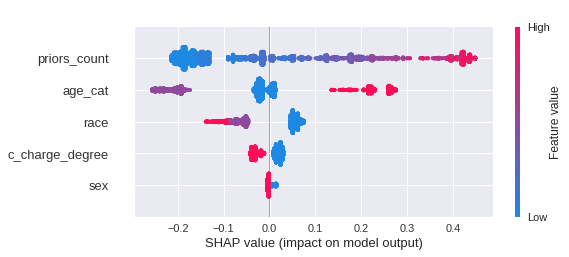

In [0]:
explainer = shap.TreeExplainer(lgbm)
shap_values =  explainer.shap_values(X)
shap.summary_plot(shap_values , X)


# Working on XGBOOST Training of the problem

In [34]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

# 'race_random_African_American',
#        'race_random_Caucasian',
X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)



[0]	test-auc:0.795938
[1000]	test-auc:0.824198
[2000]	test-auc:0.826098
[3000]	test-auc:0.827183
[4000]	test-auc:0.828013
[5000]	test-auc:0.82904
[6000]	test-auc:0.829372
[7000]	test-auc:0.829819
[8000]	test-auc:0.830071
[9000]	test-auc:0.830299
[9999]	test-auc:0.830313


(array([336., 205., 167., 241.,  98., 144., 406., 162., 193., 338., 306.,
        210., 315., 456., 274., 360., 332., 337., 142., 256.]),
 array([0.00139616, 0.050343  , 0.09928984, 0.14823669, 0.19718353,
        0.24613038, 0.2950772 , 0.34402406, 0.39297092, 0.44191775,
        0.4908646 , 0.53981143, 0.5887583 , 0.63770515, 0.68665195,
        0.7355988 , 0.78454566, 0.8334925 , 0.8824393 , 0.9313862 ,
        0.98033303], dtype=float32),
 <a list of 20 Patch objects>)

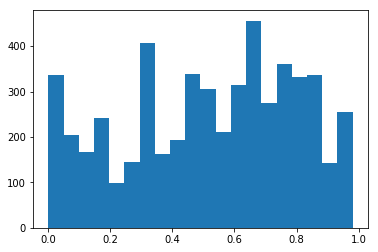

In [35]:
plt.hist(data_final['pred'], bins = 20)

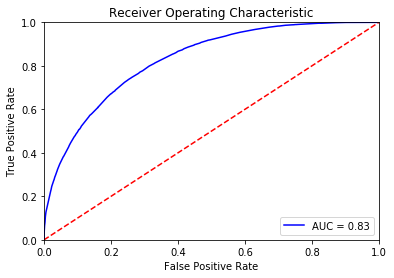

Optimal Threshold obtained using difference of TPR and FPR 0.49377143


In [36]:
fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

In [37]:
# tp_indices =  data_final[(data_final['Low']==1) & (data_final['y_pred']==1)].index
# fp_indices =  data_final[(data_final['Low']==0) & (data_final['y_pred']==1)].index
# tn_indices =  data_final[(data_final['Low']==0) & (data_final['y_pred']==0)].index
# fn_indices =  data_final[(data_final['Low']==1) & (data_final['y_pred']==0)].index

race_afam = data_final[(data_final['race_African_American']==1)].index
race_caucasian = data_final[(data_final['race_African_American']==0)].index


# print("length of TP  is " + str(len(tp_indices)))
# print("length of FP  is " + str(len(fp_indices)))
# print("length of TN  is " + str(len(tn_indices)))
# print("length of FN  is " + str(len(fn_indices)))
print("Number of Caucasian  is " + str(len(race_caucasian)))
print("Number of African American  is " + str(len(race_afam)))



location_afam  =  X.columns.get_loc("race_African_American")
location_caucasian =X.columns.get_loc("race_Caucasian")
#location_hispanic = X.columns.get_loc("race_Hispanic")
location_mis = X.columns.get_loc("c_charge_degree_M")
location_fel = X.columns.get_loc("c_charge_degree_F")
#location_rand = X.columns.get_loc("race_random_African_American")

#locations_interested = [location_afam,location_caucasian, location_rand]

Number of Caucasian  is 2103
Number of African American  is 3175


In [0]:
background = sklearn.utils.resample(X, n_samples=100, replace=False)
explainer = shap.TreeExplainer(model, data = , feature_dependence = 'independent', model_output = 'probability')
shap_values =  explainer.shap_values(X)



  0%|                   | 17/5278 [03:43<1150:11]       

In [0]:
sklearn.utils.resample?

# Randomizing race and removing the original race column

As compared to the previous mimic model of having both the race and the randomized race together in the same dataset. The following experiment truly looks at a randomized race column. The hypothesis of the experiement was motivated from the fact that since SHAP values for the original race column already captured the effect of race, thus leaving no attribution to the randomized race column.

Here we might see the in effectiveness of race blindness.

[0]	test-auc:0.803728
[1000]	test-auc:0.820614
[2000]	test-auc:0.821987
[3000]	test-auc:0.823325
[4000]	test-auc:0.823451
[5000]	test-auc:0.824115
[6000]	test-auc:0.824428
[7000]	test-auc:0.824674
[8000]	test-auc:0.824865
[9000]	test-auc:0.825453
[9999]	test-auc:0.825734


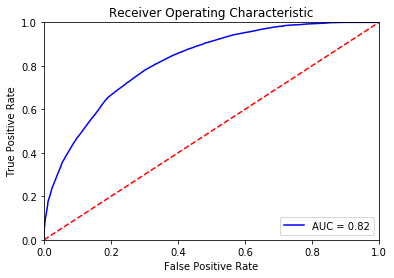

Optimal Threshold obtained using difference of TPR and FPR 0.519726


In [20]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']


X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)

fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X)



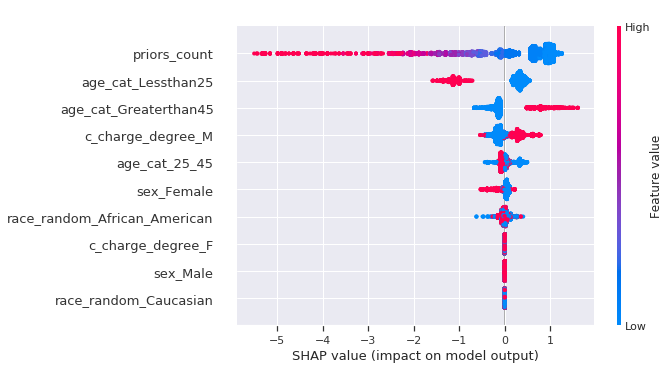

In [19]:
sns.set()
shap.summary_plot(shap_values, X)

# General Distribution for Race and  Randomized Race

In [0]:
def get_pmf(data, num_bins = 100):
  counts, bins = np.histogram(data ,bins=num_bins)
  bins = bins[:-1] + (bins[1] - bins[0])/2
  probs = counts/float(counts.sum())
  return probs

KL Divergence of the two distributions 1.0164800953547188
KL Divergence of the two distributions 1.3603177134260078


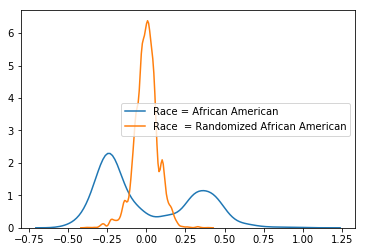

In [0]:
sns.kdeplot(shap_values[:, location_afam], label = 'Race = African American')
sns.kdeplot(shap_values[:, location_rand], label = 'Race  = Randomized African American')

pmf_rand =  get_pmf(shap_values[:, location_rand])
pmf_orig =  get_pmf(shap_values[:, location_afam])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

# Demographic Parity

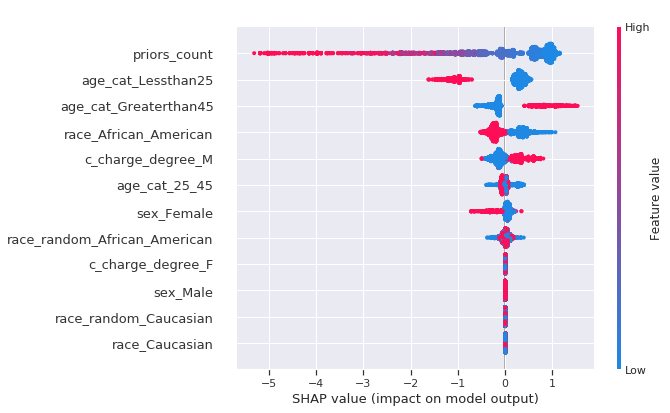

In [0]:
sns.set()
shap.summary_plot(shap_values, X)

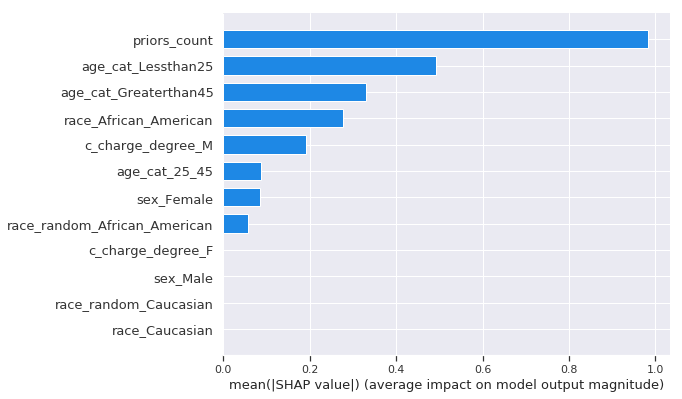

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Separation or Equalized Odds

In [0]:
Y_1_AF =  data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==1)].index
Y_1_C = data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==0)].index

Y_1_AF_random =  data_final[(data_final['is_recid']==0) & (data_final['race_random_African_American']==1)].index
Y_1_C_random = data_final[(data_final['is_recid']==0) & (data_final['race_random_African_American']==0)].index



Y_0_AF =  data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==1)].index
Y_0_C = data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==0)].index

Y_0_AF_random =  data_final[(data_final['is_recid']==1) & (data_final['race_random_African_American']==1)].index
Y_0_C_random = data_final[(data_final['is_recid']==1) & (data_final['race_random_African_American']==0)].index

print(len(Y_0_AF))
print(len(Y_0_C))
print(len(Y_0_AF_random))
print(len(Y_0_C_random))
print()

print(len(Y_1_AF))
print(len(Y_1_C))
print(len(Y_1_AF_random))
print(len(Y_1_C_random))

1773
874
1588
1059

1402
1229
1587
1044


In [0]:
X_set =  X.iloc[Y_0_AF]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_afam_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_C]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_caucasian_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_0_AF_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_afam_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_C_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_caucasian_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)



KL Divergence of the two distributions 0.7691163761363696
KL Divergence of the two distributions 0.7719855821707502


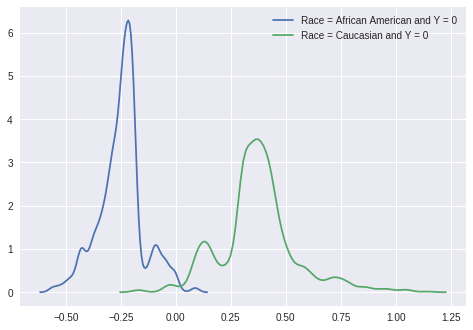

In [0]:
sns.kdeplot(y_0_afam_values[:,0], label = 'Race = African American and Y = 0')
sns.kdeplot(y_0_caucasian_values[:,0], label = 'Race = Caucasian and Y = 0')
pmf_rand =  get_pmf(y_0_afam_values[:,0])
pmf_orig =  get_pmf(y_0_caucasian_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

KL Divergence of the two distributions 0.5202265504865458
KL Divergence of the two distributions 0.5928398720299715


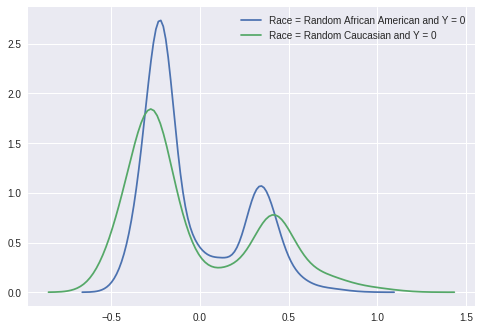

In [0]:
sns.kdeplot(y_0_afam_random_values[:,0], label = 'Race = Random African American and Y = 0')
sns.kdeplot(y_0_caucasian_random_values[:,0], label = 'Race = Random Caucasian and Y = 0')

pmf_rand =  get_pmf(y_0_afam_random_values[:,0])
pmf_orig =  get_pmf(y_0_caucasian_random_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

# Equality of Opportunity

In [0]:
X_set =  X.iloc[Y_1_AF]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_afam_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_C]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_caucasian_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_1_AF_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_afam_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_C_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_caucasian_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)



In [0]:
sns.kdeplot(y_1_afam_values[:,0], label = 'Race = African American and Y = 1')
sns.kdeplot(y_1_caucasian_values[:,0], label = 'Race = Caucasian and Y = 1')
pmf_rand =  get_pmf(y_1_afam_values[:,0])
pmf_orig =  get_pmf(y_1_caucasian_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

In [0]:
sns.kdeplot(y_1_afam_random_values[:,0], label = 'Race = Random African American and Y = 1')
sns.kdeplot(y_1_caucasian_random_values[:,0], label = 'Race = Random Caucasian and Y = 1')
pmf_rand =  get_pmf(y_1_afam_random_values[:,0])
pmf_orig =  get_pmf(y_1_caucasian_random_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

In [0]:
y_1 = pd.Index.union(tp_indices, fn_indices)
X_set =  X.iloc[y_1]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)
shap.summary_plot(shap_values_set, X_set, plot_type="bar")


# Suffciency

#### Get SHAP Values

In [0]:
print("Start working on Sufficiency")
Y_1_AF =  data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==1)].index
Y_0_AF =  data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==1)].index
X_set_Y_1_AF =  X.iloc[Y_1_AF]
X_set_Y_0_AF =  X.iloc[Y_0_AF]

AF =  data_final[(data_final['race_African_American']==1)].index
shap_values_set_Y_1_AF =  explainer.shap_values(X_set_Y_1_AF)
shap_values_set_Y_0_AF =  explainer.shap_values(X_set_Y_0_AF)

#print(shap_values_set_Y_1_AF)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_C =  data_final[(data_final['is_recid']==0) & (data_final['race_Caucasian']==1)].index
Y_0_C =  data_final[(data_final['is_recid']==1) & (data_final['race_Caucasian']==1)].index
X_set_Y_1_C =  X.iloc[Y_1_C]
X_set_Y_0_C =  X.iloc[Y_0_C]
C = data_final[(data_final['race_African_American']==0)].index
shap_values_set_Y_1_C =  explainer.shap_values(X_set_Y_1_C)
shap_values_set_Y_0_C =  explainer.shap_values(X_set_Y_0_C)

# print(shap_values_set_Y_1_C)
# shap.summary_plot(shap_values_set_Y_1_C, X_set_Y_1_C, sort = False)

# print(shap_values_set_Y_0_C)
# shap.summary_plot(shap_values_set_Y_0_C, X_set_Y_0_C, sort = False)

#shap.summary_plot(shap_values_set, X_set, sort = False)

independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']


X =  data_final.loc[:, independent_columns]
location_afam  =  X.columns.get_loc("race_African_American")
# Get the race SHAP values for AFAM and Caucasian
y_1_afam_values =  shap_values_set_Y_1_AF[:, [location_afam]]
print(len(y_1_afam_values))
y_0_afam_values =  shap_values_set_Y_0_AF[:, [location_afam]]
print(len(y_0_afam_values))
y_1_c_values =  shap_values_set_Y_1_C[:, [location_afam]]
print(len(y_1_c_values))
y_0_c_values =  shap_values_set_Y_0_C[:, [location_afam]]
print(len(y_0_c_values))

#### Data Overview

In [0]:
# plt.hist(y_1_afam_values, bins = 20, density=True)
print("African American: ", len(AF))
print("African American that are non-reoffender: ", len(X_set_Y_1_AF))
print("African American that are reoffender: ", len(X_set_Y_0_AF),'\n')
print()

print("Caucasian: ", len(C))
print("Caucasian that are non-reoffender: ", len(X_set_Y_1_C))
print("Caucasian that are reoffender: ", len(X_set_Y_0_C),'\n')

#### Visualization

In [0]:
plt.hist(y_1_afam_values, weights=np.ones(len(y_1_afam_values)) / (len(y_1_afam_values)+len(y_0_afam_values)), bins=20, label=['Race = African American and Y = 1'])
# plt.xlabel('SHAP value')
# plt.ylabel('Percentage')
# plt.show()

plt.hist(y_1_c_values, weights=np.ones(len(y_1_c_values)) / (len(y_1_c_values)+len(y_0_c_values)), bins=20, label=['Race = Caucasian and Y = 1'])
plt.title('Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Race')
plt.ylim(0, 0.25)
plt.legend()
plt.show()

bin_count = 6

plt.hist([y_1_afam_values,y_0_afam_values], bins=bin_count, label=['Y=1','Y=0'])
plt.title('SHAP Count for African American')
plt.xlabel('SHAP value')
plt.ylabel('Count')
plt.legend()
plt.show()



plt.hist([y_1_c_values,y_0_c_values], bins=bin_count, label=['Y=1','Y=0'])
plt.title('SHAP Count for Caucasian')
plt.xlabel('SHAP value')
plt.ylabel('Count')
plt.legend()
plt.show()



hist_afam1, bin_edges_afam1 = np.histogram(y_1_afam_values.ravel(), bins=bin_count)
hist_afam0, bin_edges_afam0 = np.histogram(y_0_afam_values.ravel(), bins=bin_count)
afam1_bindiv_result = np.divide(hist_afam1, np.add(hist_afam1,hist_afam0))

print(hist_afam1)
print(np.add(hist_afam1,hist_afam0))
print(afam1_bindiv_result)

hist_c1, bin_edges_c1 = np.histogram(y_1_c_values.ravel(), bins=bin_count)
hist_c0, bin_edges_c0 = np.histogram(y_0_c_values.ravel(), bins=bin_count)
c1_bindiv_result = np.divide(hist_c1, np.add(hist_c1,hist_c0))

print(hist_c1)
print(np.add(hist_c1,hist_c0))
print(c1_bindiv_result)

min_edge=min(min(bin_edges_afam1), min(bin_edges_afam0))
max_edge=max(max(bin_edges_afam1), max(bin_edges_afam0))
print('AFAM Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), afam1_bindiv_result, label='Y=1 AFAM Percentage',width=0.08, align='center')

plt.title('Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.legend()

min_edge=min(min(bin_edges_c1), min(bin_edges_c0))
max_edge=max(max(bin_edges_c1), max(bin_edges_c0))
print('CAU Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), c1_bindiv_result, label='Y=1 Caucasian Percentage',width=0.08, align='center')

plt.legend()

plt.show()


min_edge = -0.6
max_edge = 1.0
bin_count = 10
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_afam1, bin_edges_afam1 = np.histogram(y_1_afam_values.ravel(), bins=bins)
hist_afam0, bin_edges_afam0 = np.histogram(y_0_afam_values.ravel(), bins=bins)
afam1_bindiv_result = np.divide(hist_afam1, np.add(hist_afam1,hist_afam0))

hist_c1, bin_edges_c1 = np.histogram(y_1_c_values.ravel(), bins=bins)
hist_c0, bin_edges_c0 = np.histogram(y_0_c_values.ravel(), bins=bins)
c1_bindiv_result = np.divide(hist_c1, np.add(hist_c1,hist_c0))

print('Count Y=1: ', hist_afam1)
print('Count Total: ', np.add(hist_afam1,hist_afam0))
print('Percentage: ', afam1_bindiv_result)
print('Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), '\n')

print('Count Y=1: ', hist_c1)
print('Count Total: ', np.add(hist_c1,hist_c0))
print('Percentage: ', c1_bindiv_result)
print('Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), afam1_bindiv_result, label='Y=1 AFAM Percentage',width=0.08, align='center')
plt.title('Aligned Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), c1_bindiv_result, label='Y=1 Caucasian Percentage',width=0.04, align='center')
plt.legend()

plt.show()

# Age Feature
Run the same fairness criteria on the age feature

#### Get SHAP Values

In [0]:
print("Start getting SHAP for Sufficiency - Age")
Y_1_T =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_Lessthan25']==1)].index
Y_0_T =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_Lessthan25']==1)].index
X_set_Y_1_T =  X.iloc[Y_1_T]
X_set_Y_0_T =  X.iloc[Y_0_T]
shap_values_set_Y_1_T =  explainer.shap_values(X_set_Y_1_T)
shap_values_set_Y_0_T =  explainer.shap_values(X_set_Y_0_T)

#print(shap_values_set_Y_1_AF)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_M =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_25_45']==1)].index
Y_0_M =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_25_45']==1)].index
X_set_Y_1_M =  X.iloc[Y_1_M]
X_set_Y_0_M =  X.iloc[Y_0_M]

shap_values_set_Y_1_M =  explainer.shap_values(X_set_Y_1_M)
shap_values_set_Y_0_M =  explainer.shap_values(X_set_Y_0_M)
# print(shap_values_set_Y_1_M)
# shap.summary_plot(shap_values_set_Y_1_M, X_set_Y_1_M, sort = False)
# print(shap_values_set_Y_0_M)
# shap.summary_plot(shap_values_set_Y_0_M, X_set_Y_0_M, sort = False)

Y_1_S =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_Greaterthan45']==1)].index
Y_0_S =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_Greaterthan45']==1)].index
X_set_Y_1_S =  X.iloc[Y_1_S]
X_set_Y_0_S =  X.iloc[Y_0_S]

shap_values_set_Y_1_S =  explainer.shap_values(X_set_Y_1_S)
shap_values_set_Y_0_S =  explainer.shap_values(X_set_Y_0_S)

#shap.summary_plot(shap_values_set, X_set, sort = False)

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

T =  data_final[(data_final['age_cat_Lessthan25']==1)].index
M = data_final[(data_final['age_cat_25_45']==1)].index
S = data_final[(data_final['age_cat_25_45']==1)].index

X =  data_final.loc[:, independent_columns]
location_T  =  X.columns.get_loc("age_cat_Lessthan25")
location_M  =  X.columns.get_loc("age_cat_25_45")
location_S  =  X.columns.get_loc("age_cat_Greaterthan45")

# Get the race SHAP values for AFAM and Caucasian
y_1_T_values =  shap_values_set_Y_1_T[:, [location_T, location_M, location_S]]
print(len(y_1_T_values))
y_0_T_values =  shap_values_set_Y_0_T[:, [location_T, location_M, location_S]]
print(len(y_0_T_values))
y_1_M_values =  shap_values_set_Y_1_M[:, [location_T, location_M, location_S]]
print(len(y_1_M_values))
y_0_M_values =  shap_values_set_Y_0_M[:, [location_T, location_M, location_S]]
print(len(y_0_M_values))
y_1_S_values =  shap_values_set_Y_1_S[:, [location_T, location_M, location_S]]
print(len(y_1_S_values))
y_0_S_values =  shap_values_set_Y_0_S[:, [location_T, location_M, location_S]]
print(len(y_0_S_values))

# convert 2D SHAP to 1D SHAP
y_0_T_values=y_0_T_values.sum(axis=1)
y_1_T_values=y_1_T_values.sum(axis=1)
y_0_M_values=y_0_M_values.sum(axis=1)
y_1_M_values=y_1_M_values.sum(axis=1)
y_0_S_values=y_0_S_values.sum(axis=1)
y_1_S_values=y_1_S_values.sum(axis=1)

In [0]:
# plt.hist(y_1_afam_values, bins = 20, density=True)
print("Teen: ", len(T))
print("Teen that are non-reoffender: ", len(X_set_Y_1_T))
print("Teen that are reoffender: ", len(X_set_Y_0_T),'\n')
print()

print("Middle Age: ", len(M))
print("Middle Age that are non-reoffender: ", len(X_set_Y_1_M))
print("Middle Age that are reoffender: ", len(X_set_Y_0_M),'\n')

print("Senior: ", len(S))
print("Senior that are non-reoffender: ", len(X_set_Y_1_S))
print("Senior that are reoffender: ", len(X_set_Y_0_S),'\n')

## Equalized Odds

In [0]:

sns.kdeplot(y_0_T_values.ravel(), label = 'Teen and Y=0')
sns.kdeplot(y_0_M_values.ravel(), label = 'Middle Age and Y=0')
sns.kdeplot(y_0_S_values.ravel(), label = 'Senior and Y=0')

## Equalized Opportunity

In [0]:
sns.kdeplot(y_1_T_values.ravel(), label = 'Teen and Y=1')
sns.kdeplot(y_1_M_values.ravel(), label = 'Middle Age and Y=1')
sns.kdeplot(y_1_S_values.ravel(), label = 'Senior and Y=1')

## Sufficiency

In [0]:
plt.hist(y_1_T_values, weights=np.ones(len(y_1_T_values)) / (len(y_1_T_values)+len(y_0_T_values)), bins=20, label=['Age < 25 and Y = 1'])
plt.hist(y_1_M_values, weights=np.ones(len(y_1_M_values)) / (len(y_1_M_values)+len(y_0_M_values)), bins=20, label=['25 < Age < 45 and Y = 1'])
plt.hist(y_1_S_values, weights=np.ones(len(y_1_S_values)) / (len(y_1_S_values)+len(y_0_S_values)), bins=20, label=['Age > 45 and Y = 1'])
plt.title('Overall SHAP for Age Groups')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Age Group')
# plt.ylim(0, 0.25)
plt.legend()
plt.show()

# Figure 2
bin_count = 10
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bin_count)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bin_count)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bin_count)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bin_count)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bin_count)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bin_count)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

min_edge=min(min(bin_edges_t1), min(bin_edges_t0))
max_edge=max(max(bin_edges_t1), max(bin_edges_t0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), t1_bindiv_result, label='Y=1 Teen Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_m1), min(bin_edges_m0))
max_edge=max(max(bin_edges_m1), max(bin_edges_m0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), m1_bindiv_result, label='Y=1 Middle Age Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_s1), min(bin_edges_s0))
max_edge=max(max(bin_edges_s1), max(bin_edges_s0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), s1_bindiv_result, label='Y=1 Senior Percentage',width=0.05, align='center')
plt.legend()

plt.title('Sufficency Fairness Criterion - Actual Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()

# Figure 5
min_edge = -2
max_edge = 2
bin_count = 20
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bins)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bins)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bins)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bins)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bins)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bins)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), t1_bindiv_result, label='Y=1 Teen %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), m1_bindiv_result, label='Y=1 Middle Age %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), s1_bindiv_result, label='Y=1 Senior %',width=0.05, align='center')
plt.legend()


plt.title('Sufficency Fairness Criterion for Age - Aligned Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()


# Age Feature Randomized
Run the same fairness criteria on the randomized age feature

In [0]:
# data_final.info()
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F', 'age_random_25_45', 'age_random_Greaterthan45', 'age_random_Lessthan25']


X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)

fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X)

In [0]:
print("Start getting SHAP for Sufficiency - Randomized Age")
Y_1_T =  data_final[(data_final['is_recid']==0) & (data_final['age_random_Lessthan25']==1)].index
Y_0_T =  data_final[(data_final['is_recid']==1) & (data_final['age_random_Lessthan25']==1)].index
X_set_Y_1_T =  X.iloc[Y_1_T]
X_set_Y_0_T =  X.iloc[Y_0_T]
shap_values_set_Y_1_T =  explainer.shap_values(X_set_Y_1_T)
shap_values_set_Y_0_T =  explainer.shap_values(X_set_Y_0_T)
print('SHAP for Teen: ', shap_values_set_Y_1_T.shape)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_M =  data_final[(data_final['is_recid']==0) & (data_final['age_random_25_45']==1)].index
Y_0_M =  data_final[(data_final['is_recid']==1) & (data_final['age_random_25_45']==1)].index
X_set_Y_1_M =  X.iloc[Y_1_M]
X_set_Y_0_M =  X.iloc[Y_0_M]

shap_values_set_Y_1_M =  explainer.shap_values(X_set_Y_1_M)
shap_values_set_Y_0_M =  explainer.shap_values(X_set_Y_0_M)
print('SHAP for Middle Age: ', shap_values_set_Y_1_T.shape)
# print(shap_values_set_Y_1_M)
# shap.summary_plot(shap_values_set_Y_1_M, X_set_Y_1_M, sort = False)
# print(shap_values_set_Y_0_M)
# shap.summary_plot(shap_values_set_Y_0_M, X_set_Y_0_M, sort = False)

Y_1_S =  data_final[(data_final['is_recid']==0) & (data_final['age_random_Greaterthan45']==1)].index
Y_0_S =  data_final[(data_final['is_recid']==1) & (data_final['age_random_Greaterthan45']==1)].index
X_set_Y_1_S =  X.iloc[Y_1_S]
X_set_Y_0_S =  X.iloc[Y_0_S]

shap_values_set_Y_1_S =  explainer.shap_values(X_set_Y_1_S)
shap_values_set_Y_0_S =  explainer.shap_values(X_set_Y_0_S)
print('SHAP for Senior: ', shap_values_set_Y_1_T.shape)

#shap.summary_plot(shap_values_set, X_set, sort = False)

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F', 'age_random_25_45', 'age_random_Greaterthan45', 'age_random_Lessthan25']
T =  data_final[(data_final['age_random_Lessthan25']==1)].index
M = data_final[(data_final['age_random_25_45']==1)].index
S = data_final[(data_final['age_random_Greaterthan45']==1)].index

print(shap_values_set_Y_1_T.shape)

X =  data_final.loc[:, independent_columns]
location_T  =  X.columns.get_loc("age_random_Lessthan25")
location_M  =  X.columns.get_loc("age_random_25_45")
location_S  =  X.columns.get_loc("age_random_Greaterthan45")

# Get the race SHAP values for Age Groups
y_1_T_values =  shap_values_set_Y_1_T[:, [location_T, location_M, location_S]]
print(len(y_1_T_values))
y_0_T_values =  shap_values_set_Y_0_T[:, [location_T, location_M, location_S]]
print(len(y_0_T_values))
y_1_M_values =  shap_values_set_Y_1_M[:, [location_T, location_M, location_S]]
print(len(y_1_M_values))
y_0_M_values =  shap_values_set_Y_0_M[:, [location_T, location_M, location_S]]
print(len(y_0_M_values))
y_1_S_values =  shap_values_set_Y_1_S[:, [location_T, location_M, location_S]]
print(len(y_1_S_values))
y_0_S_values =  shap_values_set_Y_0_S[:, [location_T, location_M, location_S]]
print(len(y_0_S_values))

# convert 2D SHAP to 1D SHAP
y_0_T_values=y_0_T_values.sum(axis=1)
y_1_T_values=y_1_T_values.sum(axis=1)
y_0_M_values=y_0_M_values.sum(axis=1)
y_1_M_values=y_1_M_values.sum(axis=1)
y_0_S_values=y_0_S_values.sum(axis=1)
y_1_S_values=y_1_S_values.sum(axis=1)

#### Equalized Odds

In [0]:
sns.kdeplot(y_0_T_values.ravel(), label = 'Teen and Y=0')
sns.kdeplot(y_0_M_values.ravel(), label = 'Middle Age and Y=0')
sns.kdeplot(y_0_S_values.ravel(), label = 'Senior and Y=0')

#### Equalized Opportunities

In [0]:
sns.kdeplot(y_1_T_values.ravel(), label = 'Teen and Y=1')
sns.kdeplot(y_1_M_values.ravel(), label = 'Middle Age and Y=1')
sns.kdeplot(y_1_S_values.ravel(), label = 'Senior and Y=1')

#### Sufficiency

In [0]:
plt.hist(y_1_T_values, weights=np.ones(len(y_1_T_values)) / (len(y_1_T_values)+len(y_0_T_values)), bins=20, label=['Age < 25 and Y = 1'])
plt.hist(y_1_M_values, weights=np.ones(len(y_1_M_values)) / (len(y_1_M_values)+len(y_0_M_values)), bins=20, label=['25 < Age < 45 and Y = 1'])
plt.hist(y_1_S_values, weights=np.ones(len(y_1_S_values)) / (len(y_1_S_values)+len(y_0_S_values)), bins=20, label=['Age > 45 and Y = 1'])
plt.title('Overall SHAP for Age Groups')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Age Group')
# plt.ylim(0, 0.25)
plt.legend()
plt.show()

# Figure 2
bin_count = 10
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bin_count)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bin_count)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bin_count)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bin_count)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bin_count)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bin_count)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

min_edge=min(min(bin_edges_t1), min(bin_edges_t0))
max_edge=max(max(bin_edges_t1), max(bin_edges_t0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), t1_bindiv_result, label='Y=1 Teen Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_m1), min(bin_edges_m0))
max_edge=max(max(bin_edges_m1), max(bin_edges_m0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), m1_bindiv_result, label='Y=1 Middle Age Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_s1), min(bin_edges_s0))
max_edge=max(max(bin_edges_s1), max(bin_edges_s0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), s1_bindiv_result, label='Y=1 Senior Percentage',width=0.05, align='center')
plt.legend()

plt.title('Sufficency Fairness Criterion - Actual Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()

# Figure 5
min_edge = -2
max_edge = 2
bin_count = 20
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bins)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bins)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bins)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bins)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bins)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bins)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), t1_bindiv_result, label='Y=1 Teen %',width=0.1, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), m1_bindiv_result, label='Y=1 Middle Age %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), s1_bindiv_result, label='Y=1 Senior %',width=0.02, align='center')
plt.legend()


plt.title('Sufficency Fairness Criterion for Age - Aligned Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()


# Recourse using Explanations  model training
Code taken from the paper fairness and calibrations and modified

Things to do. 
1. Look at two post processing techniques. Equlized Odds and Calibrated equalized odds
2. Define a metric to come up with a better recourse solution

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

# 'race_random_African_American',
#        'race_random_Caucasian',
X =  data_final.loc[:, independent_columns]
data_final['outcome'] =  1 - data_final['is_recid']
y =  data_final['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"logloss",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model_calibrated = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="logloss" , num_boost_round=10)
data_final['pred'] = model_calibrated.predict (xgb_full)


#locations_interested = [location_afam,location_caucasian, location_rand]


[0]	test-logloss:0.692829
[1000]	test-logloss:0.598657
[2000]	test-logloss:0.590031
[3000]	test-logloss:0.586955
[4000]	test-logloss:0.585007
[5000]	test-logloss:0.58363
[6000]	test-logloss:0.58234
[7000]	test-logloss:0.581483
[8000]	test-logloss:0.580824
[9000]	test-logloss:0.57998
[9999]	test-logloss:0.579343


In [0]:
shap_file_name="shap_probability_values.csv" 

try:  
  print("Shap Values file found")
  shap_values =  pd.read_csv(shap_file_name).values
except:
  print("Shap Values file not found")

  background = sklearn.utils.resample(X, n_samples=100, replace=True)
  explainer = shap.TreeExplainer(model_calibrated ,background, feature_dependence = 'independent', model_output = 'probability')
  shap_values =  explainer.shap_values(X)
  shap_df1 = pd.DataFrame(shap_values, columns=independent_columns)
  shap_df1.to_csv(shap_file_name, index = False)
finally:
  
  print(shap_values)


race_afam = data_final[(data_final['race_African_American']==1)].index

race_caucasian = data_final[(data_final['race_African_American']==0)].index


print("Number of Caucasian  is " + str(len(race_caucasian)))
print("Number of African American  is " + str(len(race_afam)))


location_afam  =  X.columns.get_loc("race_African_American")
location_caucasian =X.columns.get_loc("race_Caucasian")
location_mis = X.columns.get_loc("c_charge_degree_M")
location_fel = X.columns.get_loc("c_charge_degree_F")


Shap Values file found
[[ 0.16315034 -0.00567695 -0.00903823 ...  0.          0.00059408
   0.        ]
 [-0.14103569 -0.0103211  -0.03979435 ...  0.         -0.02026377
   0.        ]
 [-0.30976403  0.02661651 -0.02146385 ...  0.         -0.00941742
   0.        ]
 ...
 [ 0.18868435 -0.00587414 -0.01243486 ...  0.         -0.00052342
   0.        ]
 [ 0.18868435 -0.00587414 -0.01243486 ...  0.         -0.00052342
   0.        ]
 [-0.09499612 -0.00416244 -0.03347641 ...  0.          0.0406883
   0.        ]]
Number of Caucasian  is 2103
Number of African American  is 3175


In [0]:
shap_df = pd.DataFrame(shap_values, columns =independent_columns)
shap_df.head()

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F
0,0.163150,-0.005677,-0.009038,0.031686,-0.001032,0.0,-0.014156,0.0,0.000594,0.0
1,-0.141036,-0.010321,-0.039794,-0.151572,-0.011966,0.0,-0.022313,0.0,-0.020264,0.0
2,-0.309764,0.026617,-0.021464,0.033815,0.057778,0.0,-0.011621,0.0,-0.009417,0.0
3,0.158147,-0.013117,-0.013298,0.020078,0.004213,0.0,0.063042,0.0,0.057022,0.0
4,0.147119,-0.015706,-0.018629,0.029867,0.012154,0.0,0.000470,0.0,-0.010718,0.0


# Recourse Code

In [0]:
shap_df = pd.DataFrame(shap_values, columns=independent_columns)

## Creating the dataset for compas values
data_final['id'] =  np.arange(0, data_final.shape[0])
shap_race = (shap_values[:, location_afam])
group = X.iloc[:, location_afam]
label = data_final['outcome']
pred =  data_final['pred']
id = data_final['id']

data_recourse = pd.DataFrame({'id':id, 'shap':shap_race,'label':label,'group':group, 'prediction':pred})

#data_final.head()
data_recourse.head()

,id,shap,label,group,prediction
0,0,-0.001032,0,1,0.711674
1,1,-0.011966,0,1,0.148882
2,2,0.057778,0,0,0.312090
3,3,0.004213,1,0,0.822234
4,4,0.012154,1,0,0.690704


In [0]:
# print(data_recourse[data_recourse.id.isin([798])])
# print(data_final.loc[[798]])
# print(shap_values[798])
# print(np.sum(shap_values[798]))
# print(shap_values.shape)

# print(shap_df.iloc[798])

Parts of the code below are adopted from the  code for the papers One Fairness and Calibration 
https://github.com/gpleiss/equalized_odds_and_calibration

In [0]:
class Model(namedtuple('Model', 'id shap pred label')):
  
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Model(self.id, self.shap, pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate, w_fp = 1, w_fn = 1):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(w_fp *fp_rate + w_fn *fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = w_fp*fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            w_fn*fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res
    
    def calib_eq_odds(self, other, fp_rate, fn_rate, shap_enabled =  False, mix_rates=None):
        if mix_rates is None:
          if fn_rate == 0:
              self_cost = self.fp_cost()
              other_cost = other.fp_cost()
              print(self_cost, other_cost)
              self_trivial_cost = self.trivial().fp_cost()
              other_trivial_cost = other.trivial().fp_cost()
          elif fp_rate == 0:
              self_cost = self.fn_cost()
              other_cost = other.fn_cost()
              self_trivial_cost = self.trivial().fn_cost()
              other_trivial_cost = other.trivial().fn_cost()
          else:
              w_fp =1
              w_fn =1
              self_cost = self.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_cost = other.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)

  #         print("The costs are ", self_cost, other_cost, self_trivial_cost, other_trivial_cost)
          other_costs_more = other_cost > self_cost
          self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
          other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)
          print("The mix_rates are ", self_mix_rate, other_mix_rate)
        else:
          self_mix_rate = mix_rates[0]
          other_mix_rate = mix_rates[1]
        # New classifiers
        
#         self_indices = np.random.permutation(len(self.pred))[:int(self_mix_rate * len(self.pred))]
#         self_new_pred = self.pred.copy()
#         self_new_pred[self_indices] = self.base_rate()
#         calib_eq_odds_self = Model(self.id, self.shap, self_new_pred, self.label)

#         print("Running the post processing for group 0 ")
        if shap_enabled:
          self_changed_id, self_new_pred = self.shap_fair_individuals_calibrated(self_mix_rate, advantaged  = True)
        else:
          self_changed_id, self_new_pred = self.randomized_fair_individuals_calibrated(self_mix_rate)
        
        
       
          
        calib_eq_odds_self = Model(self_changed_id, self.shap, self_new_pred, self.label)
        
        if self_mix_rate >0:
          print("Changing SELF Model--------------- for self mix rate ", self_mix_rate)
#           print(self_changed_id)
          df = self.get_pandas_df()
#           print(df.head(2))
#           df.loc[self_changed_id,'pred'].hist()
#           plt.title('Prediction')
#           plt.show()
          
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=self.base_rate(), color='r', linestyle='-')
          plt.title("Choosing " +str(len(self_changed_id)) + " Individuals from " + str(len(self_changed_id)) + "individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(self_new_pred==self.pred))


#         other_indices = np.random.permutation(len(other.pred))[:int(other_mix_rate * len(other.pred))]
#         other_new_pred = other.pred.copy()
#         other_new_pred[other_indices] = other.base_rate()
#         calib_eq_odds_other = Model(other.id, other.shap, other_new_pred, other.label)

        if shap_enabled:
          other_changed_id, other_new_pred = other.shap_fair_individuals_calibrated(other_mix_rate, advantaged = False)
        else:
          other_changed_id, other_new_pred = other.randomized_fair_individuals_calibrated(other_mix_rate)
        sns.set(rc={'figure.figsize':(5.7,5.27)})

        
          
        calib_eq_odds_other = Model(other_changed_id, other.shap, other_new_pred, other.label)
    
        if other_mix_rate >0:
          print("Changing Other Model--------------- for other mix rate ", other_mix_rate)
#           print(other_changed_id)
          df = other.get_pandas_df()
#           print(df.head(2))
#           df.loc[other_changed_id,'pred'].hist()
#           plt.title('Prediction Distribution')
#           plt.show()
    
#           df.loc[other_changed_id,'shap'].hist()
#           plt.title('SHAp Value Distribution')

#           plt.show()
#           sns.scatterplot(x =df.loc[other_changed_id,'shap'], y= df.loc[other_changed_id,'pred'])
#           plt.title('')
#           plt.axhline(y=other.base_rate(), color='r', linestyle='-')

#           plt.show()
          sns.set(rc={'figure.figsize':(12.7,8.27)})
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=other.base_rate(), color='g', linestyle='--', linewidth = 5)
          plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)
          plt.xlim(-0.1, 0.1)
          plt.title("Need to choose " +str(len(other_changed_id)) + " people from " + str(len(other.shap)) + " individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(other_new_pred==other.pred))
        

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other
          
    def shap_fair_individuals_calibrated(self, mix_rate , advantaged):
        total = len(self.id)
        num_changed =int(mix_rate * total)
        df = self.get_pandas_df()
        print("In SHAP Method Number of people changed %d and total number %d " % (num_changed, total) )

        base_rate = self.base_rate()
        if advantaged:
          if mix_rate > 0:
            print("Redistributing Predictions for Advantaged Group")
            
          

            

#           df['except_race'] =  df['pred'] - df['shap']
          changed_indices = df.sort_values('shap', ascending = False).index[:num_changed]
#           changed_indices = df.sort_values('except_race', ascending = False).index[:num_changed]

          df.loc[changed_indices, 'pred'] = self.base_rate()
  #         print("After changning pred value")
  #         print(df.head())
        else:
          if mix_rate > 0:
            print("Redistributing Predictions for Dis Advantaged Group")
            
          quadrant_1 = df[(df['shap'] > 0) & (df['pred'] > base_rate)].index
          quadrant_2 = df[(df['shap'] < 0) & (df['pred'] > base_rate)].index
          quadrant_3 = df[(df['shap'] <= 0) & (df['pred'] <= base_rate)].index
          quadrant_4 = df[(df['shap'] >= 0)& (df['pred'] <= base_rate)].index
          df['distance'] =  np.sqrt(np.square(df['shap']) + np.square(df['pred'] - base_rate))  
          print("Number of people in each quadrant ", len(quadrant_1),len(quadrant_2),len(quadrant_3),len(quadrant_4))
          
          required_changed_ids = num_changed
          print(required_changed_ids)
          changed_indices1 = (list(df.loc[(quadrant_1.union(quadrant_3))].sort_values('distance', ascending = False).index[:required_changed_ids]))
          print("People taken from Quadrant 1 and 3 ", len(changed_indices1))
          required_changed_ids -= len(changed_indices1)
          print("ID 's left to take  Adfter Quadrant 1 and 3 ", required_changed_ids)
          changed_indices2 = list(df.loc[quadrant_2.union(quadrant_4)].sort_values('distance', ascending = True).index[:required_changed_ids])
          required_changed_ids -= len(changed_indices2)
          print("Number of ids changed in the end ", len(changed_indices2))
          changed_indices = changed_indices1+ changed_indices2
            
          #changed_indices = df.sort_values('shap', ascending = True).index[:num_changed]
          
          
          df.loc[changed_indices, 'pred'] = self.base_rate()
          

          

        return changed_indices, df.pred.copy()
    
    
    
    def randomized_fair_individuals_calibrated(self, mix_rate):
        total = len(self.id)
        changed_indices = np.random.permutation(self.id)[:int(mix_rate * total)]
#         print("In randmoized Number of people changed %d and total number %d " % (len(changed_indices), total) ) 
      
        df = self.get_pandas_df()
        
        df.loc[changed_indices, 'pred'] = self.base_rate()
#         print("After changning pred value")
#         print(df.loc[changed_indices].head(10))
# 
        return changed_indices, df.pred.copy() 

    def randomized_fair_individuals_equalized(self, p2p, n2p):
        from sklearn.utils import shuffle

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos =  shuffle(original_pos)     
        p2n_indices = original_pos.head(no_p2n).index
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        n2p_indices = original_neg.head(no_n2p).index
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()

    def shap_fair_individuals_equalized(self, p2p, n2p):

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        # Flipping positive predictions for people with lowest prediction without their race
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos['pred_except_race_shap'] = original_pos['pred']-original_pos['shap']
        p2n_indices = np.asarray(original_pos.sort_values('pred_except_race_shap', ascending = True).index[:no_p2n])
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        # Flipping Negative Predictions for people with highest contribution except SHAP
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        original_neg['pred_except_race_shap'] = original_neg['pred']-original_neg['shap']
        n2p_indices = np.asarray(original_neg.sort_values('pred_except_race_shap', ascending = False).index[:no_n2p])
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()
    
    def get_pandas_df(self):
        a = pd.DataFrame({'id':self.id, 'shap':self.shap,'label':self.label, 'pred':self.pred})
        a.set_index('id', inplace =  True)
        return a
        
    def get_changed_id(self):
      return self.id

    def eq_odds(self, other, shap_enabled =  False, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(other)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        print("sp2p, sn2p, op2p, on2p ", sp2p, sn2p, op2p, on2p)
#         self_fair_pred = self.pred.copy()
        ## Original Positive Predictions
#         self_pp_indices, = np.nonzero(self.pred.round())        
        ## Original Negative Predictions
#         self_pn_indices, = np.nonzero(1 - self.pred.round())
        
        
#         np.random.shuffle(self_pp_indices)
#         np.random.shuffle(self_pn_indices)
        
        
#         print("Self Negative to Postive Rate ", sn2p)
#         #print("Self Postive Indices Shuffled ", self_pp_indices[:5])
        
#         self_n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
#         print("Length of self n2p indices ", len(self_n2p_indices))
#         #print("Before ", self_fair_pred)
#         self_fair_pred[self_n2p_indices] = 1 - self_fair_pred[self_n2p_indices]
#         #print("After ", self_fair_pred)
        
#         print("Self Positive to Negative Rate ", 1 - sp2p)
                
#         self_p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
#         print("Length of self p2n indices ", len(self_p2n_indices))

#         #print("Before ", self_fair_pred[self_p2n_indices])

#         self_fair_pred[self_p2n_indices] = 1 - self_fair_pred[self_p2n_indices]
#         #print("After ", self_fair_pred[self_p2n_indices])
#         self_changed_id =  np.append(self_p2n_indices, self_n2p_indices)
        df_self = self.get_pandas_df()
        if shap_enabled:
           print("using SHAP based selection of individuals for self ")
           self_changed_id, self_fair_pred = self.shap_fair_individuals_equalized(sp2p, sn2p)
      
        else:
          print("using random based selection of individuals for self ")
          self_changed_id, self_fair_pred = self.randomized_fair_individuals_equalized(sp2p, sn2p)

        df_self.loc[self_changed_id, 'pred'].hist()
        plt.show()
        df_self.loc[self_changed_id, 'shap'].hist()
        plt.show()
#         othr_fair_pred = othr.pred.copy()
#         othr_pp_indices, = np.nonzero(othr.pred.round())
#         othr_pn_indices, = np.nonzero(1 - othr.pred.round())
#         np.random.shuffle(othr_pp_indices)
#         np.random.shuffle(othr_pn_indices)
#         print("Other Negative to Postive Rate ", on2p)

#         other_n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
#         print("Length of Other n2p indices ", len(other_n2p_indices))

        
#         othr_fair_pred[other_n2p_indices] = 1 - othr_fair_pred[other_n2p_indices]

#         print("Other Negative to Postive Rate ", 1 - op2p)
        
#         other_p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
#         print("Length of Other p2n indices ", len(other_p2n_indices))

#         othr_fair_pred[other_p2n_indices] = 1 - othr_fair_pred[other_p2n_indices]
#         other_changed_id =  np.append(other_p2n_indices, other_n2p_indices)
#         print("Lengths of total other changed ids ", len(other_changed_id))
        df_other =  other.get_pandas_df()
        if shap_enabled:
          print("using SHAP based selection of individuals for other ")
          other_changed_id, other_fair_pred = other.shap_fair_individuals_equalized(op2p,on2p)
        else:
          print("using  random selection of individuals for other ")
          other_changed_id, other_fair_pred = other.randomized_fair_individuals_equalized(op2p,on2p)
        df_other.loc[other_changed_id,'pred'].hist()
        plt.show()

        df_other.loc[other_changed_id,'shap'].hist()
        plt.show()

        fair_self = Model(self_changed_id, self.shap, self_fair_pred, self.label)
        fair_other = Model(other_changed_id, other.shap, other_fair_pred, other.label)
  
        
        if not has_mix_rates:
            return fair_self, fair_other, mix_rates
        else:
            return fair_self, fair_other

          
          
    def eq_odds_optimal_mix_rates(self, othr):
      
        """Function to calculate mix rates for equalized odds"""
        np.random.seed(34)
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

      

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [0]:
""# Cost constraint
cost_constraint = 'weighted'

if cost_constraint == 'fnr':
    fn_rate = 1
    fp_rate = 0
elif cost_constraint == 'fpr':
    fn_rate = 0
    fp_rate = 1
elif cost_constraint == 'weighted':
    fn_rate = 1
    fp_rate = 1
    
    
test_and_val_data = data_recourse
print(test_and_val_data.head())

# Randomly split the data into two sets - one for computing the fairness constants
np.random.seed(42)
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]


# Create model objects - one for each group, validation and test
group_0_val_data = val_data[val_data['group'] == 0]
group_1_val_data = val_data[val_data['group'] == 1]
group_0_test_data = test_data[test_data['group'] == 0]
group_1_test_data = test_data[test_data['group'] == 1]

# print(group_0_val_data.head(1))
# print(group_1_val_data.head(1))
# print(group_0_test_data.head(1))
# print(group_1_test_data.head(1))



group_0_val_model = Model(group_0_val_data['id'].as_matrix(),  group_0_val_data['shap'].as_matrix(), group_0_val_data['prediction'].as_matrix(), 
                          group_0_val_data['label'].as_matrix())
group_1_val_model = Model(group_1_val_data['id'].as_matrix(), group_1_val_data['shap'].as_matrix(), group_1_val_data['prediction'].as_matrix(),
                          group_1_val_data['label'].as_matrix())
group_0_test_model = Model(group_0_test_data['id'].as_matrix(), group_0_test_data['shap'].as_matrix(), group_0_test_data['prediction'].as_matrix(), 
                           group_0_test_data['label'].as_matrix())
group_1_test_model = Model(group_1_test_data['id'].as_matrix(), group_1_test_data['shap'].as_matrix(), group_1_test_data['prediction'].as_matrix(), 
                           group_1_test_data['label'].as_matrix())

   id      shap  label  group  prediction
0   0 -0.001032      0      1    0.711674
1   1 -0.011966      0      1    0.148882
2   2  0.057778      0      0    0.312090
3   3  0.004213      1      0    0.822234
4   4  0.012154      1      0    0.690704


# Equalized Odds as described by paper Equality of Opportunity in Supervised Learning

sp2p, sn2p, op2p, on2p  [0.80480453] [4.16333031e-23] [1.] [0.31791957]
using random based selection of individuals for self 


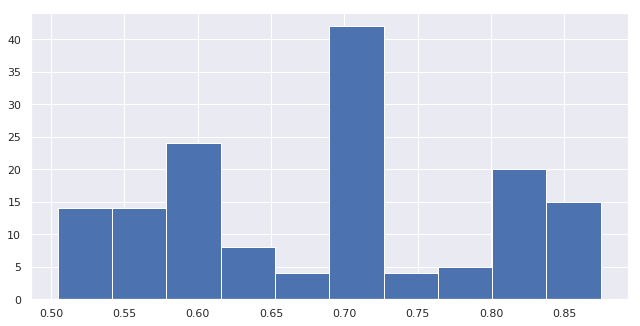

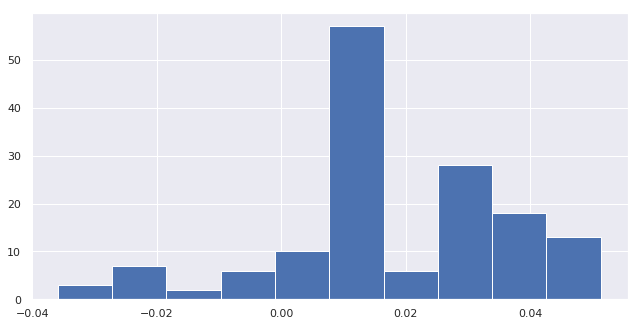

using  random selection of individuals for other 


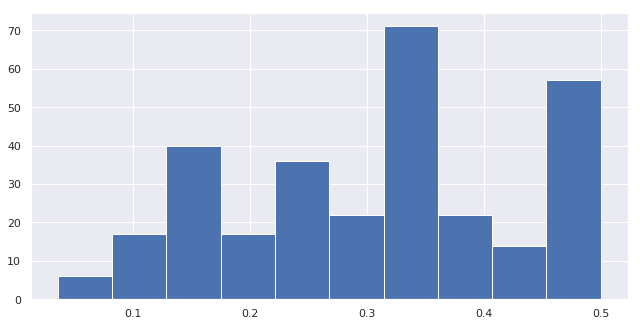

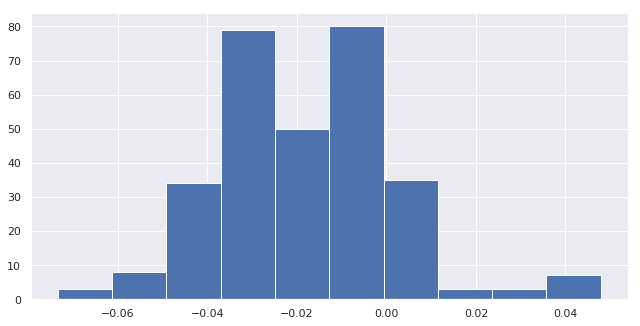

------------------Calculating mix_Rates for test models--------------------------------
sp2p, sn2p, op2p, on2p  [0.80480453] [4.16333031e-23] [1.] [0.31791957]
using random based selection of individuals for self 


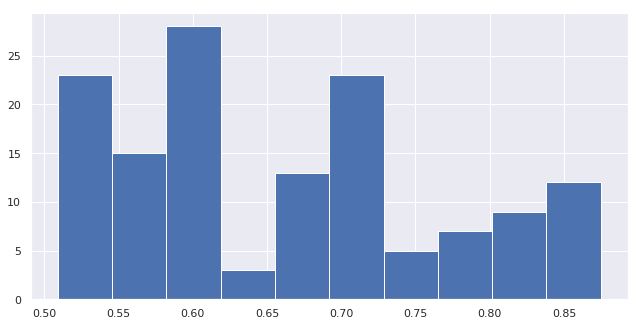

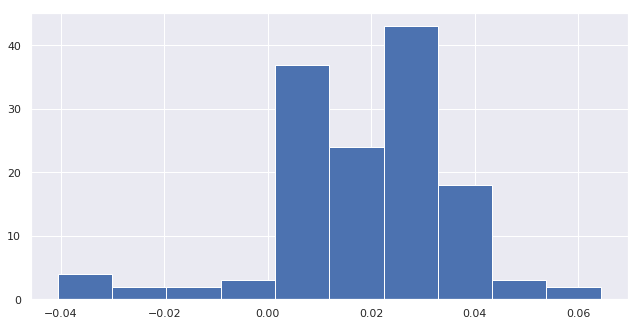

using  random selection of individuals for other 


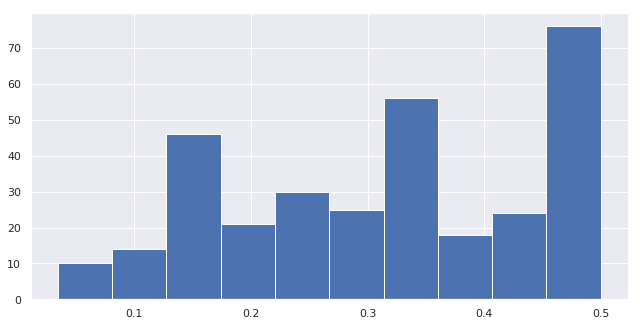

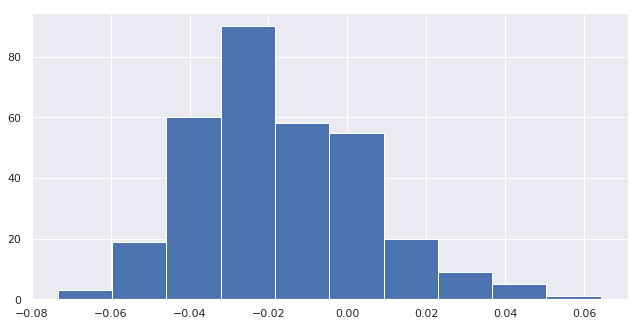

Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

Equalized odds group 0 model:
Accuracy:	0.629
F.P. cost:	0.465
F.N. cost:	0.415
Base rate:	0.582
Avg. score:	0.535

Equalized odds group 1 model:
Accuracy:	0.612
F.P. cost:	0.462
F.N. cost:	0.419
Base rate:	0.448
Avg. score:	0.515



In [0]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, False,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

sp2p, sn2p, op2p, on2p  [0.80480453] [1.27415888e-22] [1.] [0.31791957]
using SHAP based selection of individuals for self 


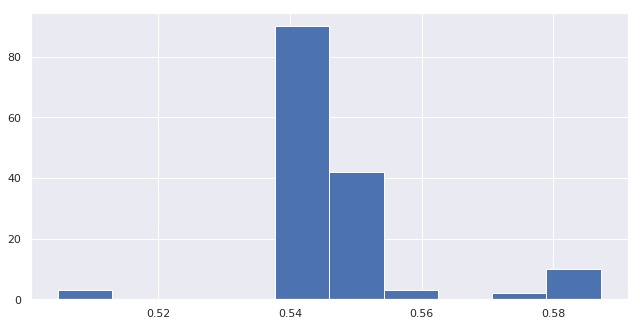

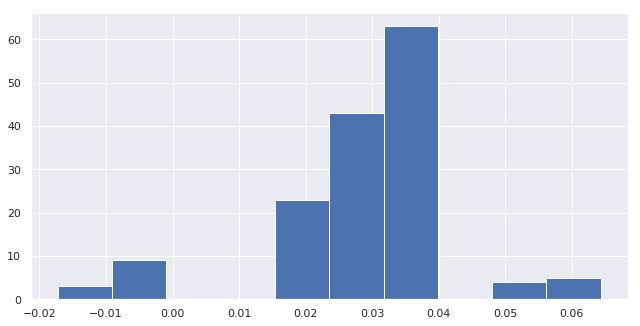

using SHAP based selection of individuals for other 


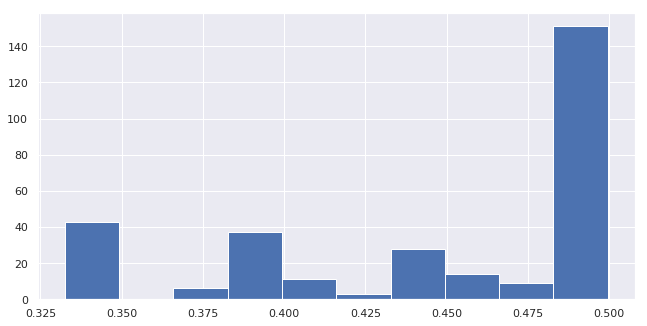

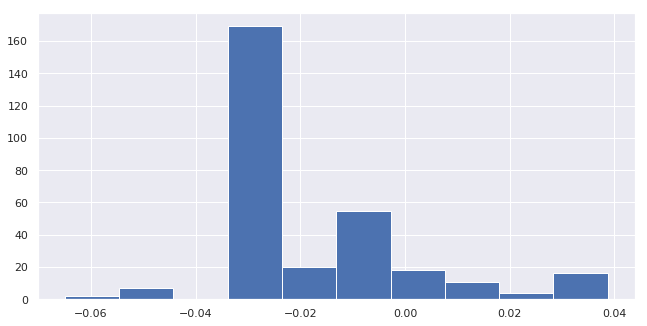

------------------Calculating mix_Rates for test models--------------------------------
sp2p, sn2p, op2p, on2p  [0.80480453] [1.27415888e-22] [1.] [0.31791957]
using SHAP based selection of individuals for self 


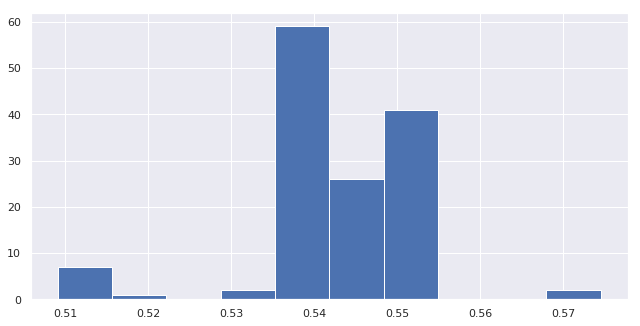

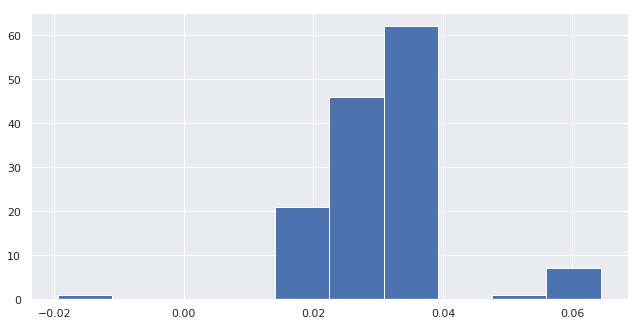

using SHAP based selection of individuals for other 


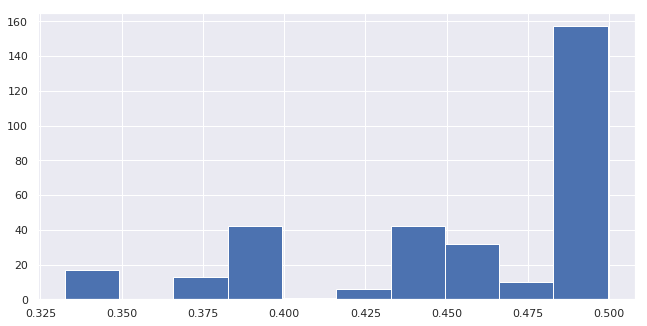

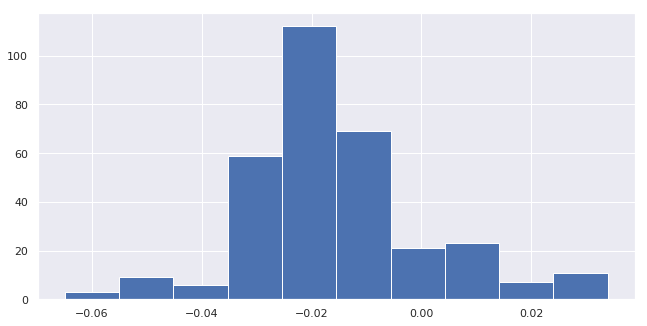

Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

Equalized odds group 0 model:
Accuracy:	0.658
F.P. cost:	0.480
F.N. cost:	0.369
Base rate:	0.582
Avg. score:	0.568

Equalized odds group 1 model:
Accuracy:	0.665
F.P. cost:	0.380
F.N. cost:	0.441
Base rate:	0.448
Avg. score:	0.460



In [0]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model, True)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, True,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

In [0]:
## Referencee!!

_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

sp2p, sn2p, op2p, on2p  [0.80480453] [4.16333964e-23] [1.] [0.31791957]
Self Negative to Postive Rate  [4.16333964e-23]
Length of self n2p indices  0
Self Positive to Negative Rate  [0.19519547]
Length of self p2n indices  150
Other Negative to Postive Rate  [0.31791957]
Length of Other n2p indices  302
Other Negative to Postive Rate  [0.]
Length of Other p2n indices  0
Lengths of total other changed ids  302
------------------Calculating mix_Rates for test models--------------------------------
sp2p, sn2p, op2p, on2p  [0.80480453] [4.16333964e-23] [1.] [0.31791957]
Self Negative to Postive Rate  [4.16333964e-23]
Length of self n2p indices  0
Self Positive to Negative Rate  [0.19519547]
Length of self p2n indices  138
Other Negative to Postive Rate  [0.31791957]
Length of Other n2p indices  320
Other Negative to Postive Rate  [0.]
Length of Other p2n indices  0
Lengths of total other changed ids  320
Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0

# Calibrated Equalized Odds

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


The mix_rates are  0 0.14421200256786165
Number of people with equal predictions in self  1084
Changing Other Model--------------- for other mix rate  0.14421200256786165


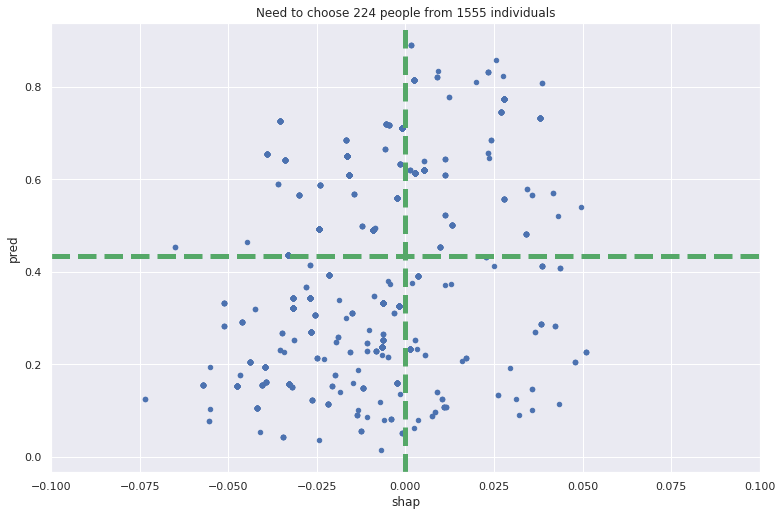

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



---------------Calculated Mix Rates and Applying to test models-----------

Number of people with equal predictions in self  1019
Changing Other Model--------------- for other mix rate  0.14421200256786165


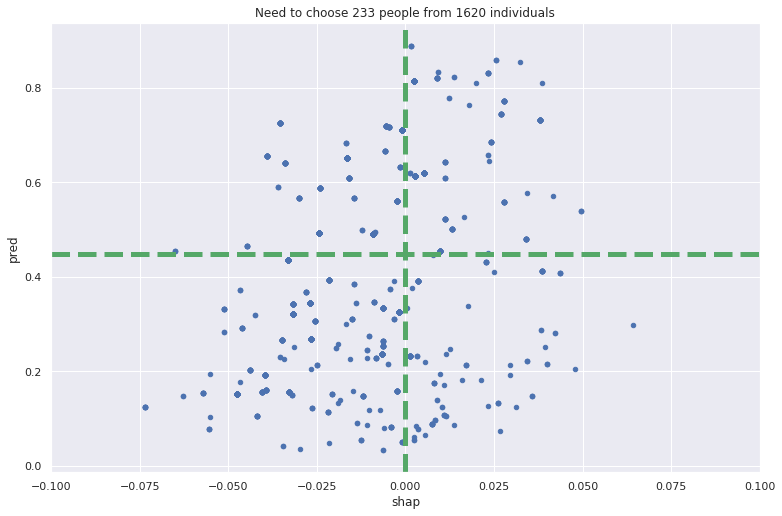


Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

Randomized Calibrated Equalized odds group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Randomized Calibrated Equalized odds group 1 model:
Accuracy:	0.665
F.P. cost:	0.371
F.N. cost:	0.469
Base rate:	0.448
Avg. score:	0.443



In [0]:
# Find mixing rates for equalized odds models
_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate)

# Apply the mixing rates to the test models

print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,False,
                                                                                         mix_rates)




# Print results on test model

print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('Randomized Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
print('Randomized Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))

The mix_rates are  0 0.14421200256786165
In SHAP Method Number of people changed 0 and total number 1084 
Number of people with equal predictions in self  1084
In SHAP Method Number of people changed 224 and total number 1555 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  279 528 630 118
224
People taken from Quadrant 1 and 3  224
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Changing Other Model--------------- for other mix rate  0.14421200256786165


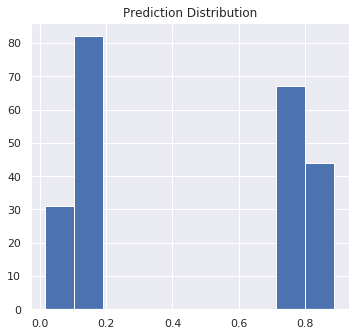

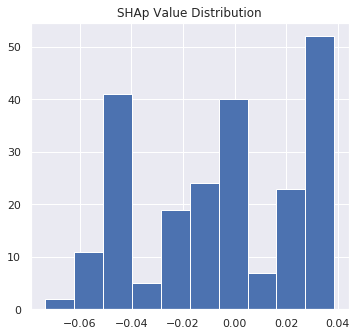

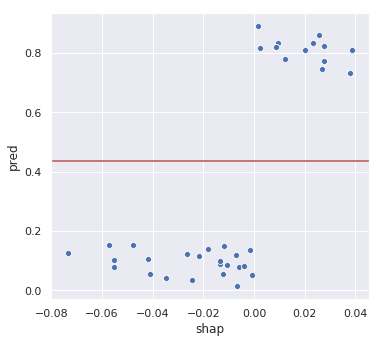


---------------Calculated Mix Rates and Applying to test models-----------

In SHAP Method Number of people changed 0 and total number 1019 
Number of people with equal predictions in self  1019
In SHAP Method Number of people changed 233 and total number 1620 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  321 489 674 136
233
People taken from Quadrant 1 and 3  233
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Changing Other Model--------------- for other mix rate  0.14421200256786165


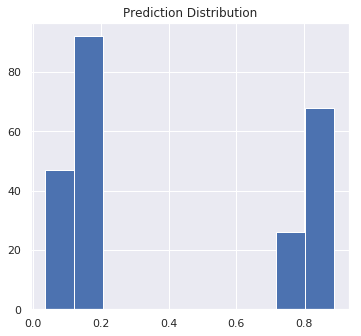

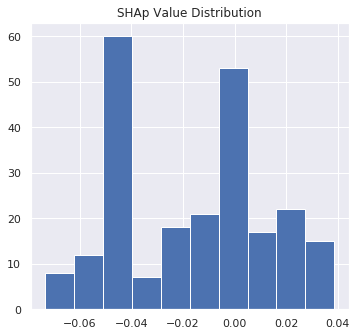

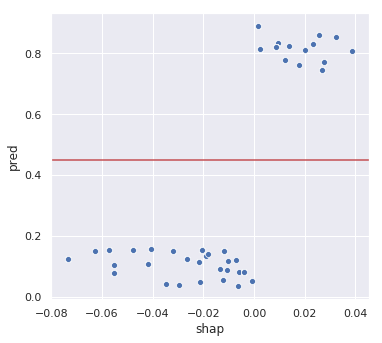


Original group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

Original group 1 model:
Accuracy:	0.680
F.P. cost:	0.360
F.N. cost:	0.459
Base rate:	0.448
Avg. score:	0.441

SHAP Fairness Calibrated Equalized odds group 0 model:
Accuracy:	0.668
F.P. cost:	0.492
F.N. cost:	0.358
Base rate:	0.582
Avg. score:	0.579

SHAP Fairness Calibrated Equalized odds group 1 model:
Accuracy:	0.643
F.P. cost:	0.399
F.N. cost:	0.491
Base rate:	0.448
Avg. score:	0.448



In [0]:

_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate, True)



print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
 
calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,True,
                                                                                         mix_rates)




# Print results on test model
print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('SHAP Fairness Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model_shap))
print('SHAP Fairness Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model_shap))

Slope of group 0 - 1.4
Slope for group 1 - 0.81

In [0]:
shap_df = pd.DataFrame(shap_values, columns = independent_columns)
shap_changed_ids = calib_eq_odds_group_1_test_model_shap.get_changed_id()
shap_pred = data_final.loc[shap_changed_ids, 'pred']
shap_shap = shap_df.loc[shap_changed_ids, 'race_African_American']

randomized_changed_ids =  calib_eq_odds_group_1_test_model.get_changed_id()
random_pred = data_final.loc[randomized_changed_ids, 'pred']
random_shap = shap_df.loc[randomized_changed_ids, 'race_African_American']


base_rate =  calib_eq_odds_group_1_test_model_shap.base_rate()

common_ids = set(shap_changed_ids).intersection(set(randomized_changed_ids))
print(common_ids)
print("The lenght of the unique ids in shap is %d" % len(np.unique(shap_changed_ids)))
print("The lenght of the unique ids in randmoized is %d" % len(np.unique(randomized_changed_ids)))
print("The lenght of the unique ids in common to shap and random is %d" % len(np.unique(list(common_ids))))

shap_changed_data =  data_final.loc[shap_changed_ids, independent_columns + ['pred']]
randomized_changed_data =  data_final.loc[randomized_changed_ids, independent_columns + ['pred']]

print("The lenght of the shap_shap list is %d" % len(shap_shap))
print( len(shap_shap))


{3584, 1796, 1285, 3590, 4872, 396, 4366, 3345, 532, 3605, 534, 1688, 4635, 2972, 4639, 1570, 1448, 3241, 687, 1331, 4670, 1087, 450, 3907, 3653, 4815, 4818, 4458, 2027, 4718, 1519, 4594, 3317, 3324}
The lenght of the unique ids in shap is 233
The lenght of the unique ids in randmoized is 233
The lenght of the unique ids in common to shap and random is 34
The lenght of the shap_shap list is 233
233


<class 'module'>


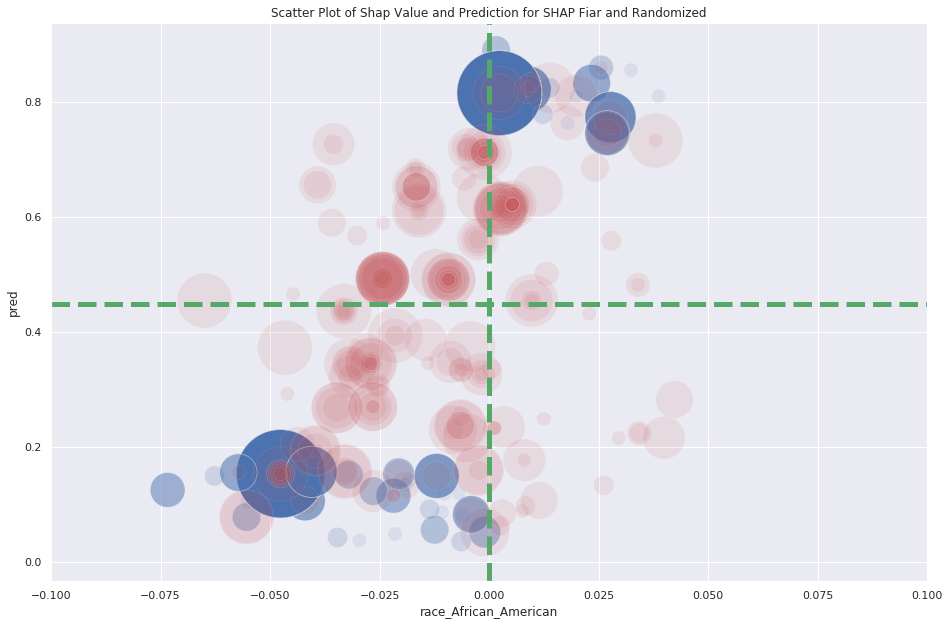

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,10.27)})
print(type(shap))
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]

sns.scatterplot(shap_shap, shap_pred, color = 'b', alpha = 0.1, s = weights_shap)
sns.scatterplot(random_shap, random_pred, color = 'r', alpha = 0.1, s = weights_random)
plt.xlim([-0.1,0.1])
plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fiar and Randomized')
plt.axhline(y=base_rate, color='g', linestyle='--', linewidth = 5)
plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)

<class 'module'>


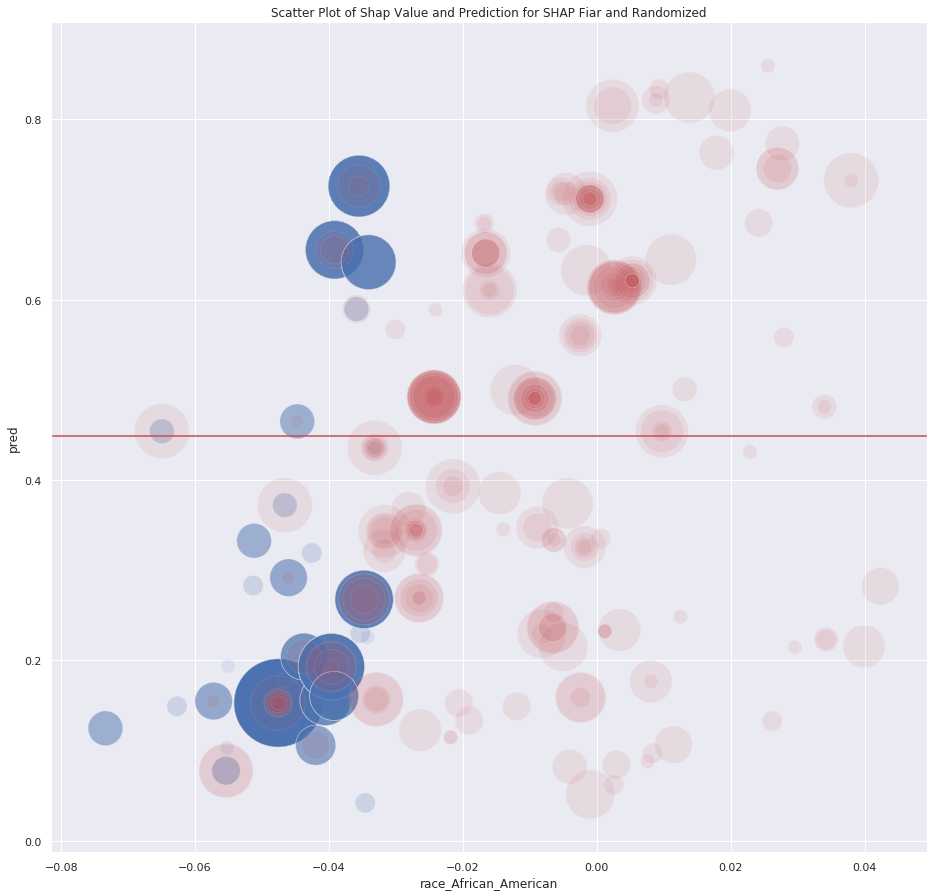

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,15.27)})
print(type(shap))
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]

sns.scatterplot(shap_shap, shap_pred, color = 'b', alpha = 0.1, s = weights_shap)
sns.scatterplot(random_shap, random_pred, color = 'r', alpha = 0.1, s = weights_random)

plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fiar and Randomized')
plt.axhline(y=base_rate, color='r', linestyle='-')

<class 'module'>


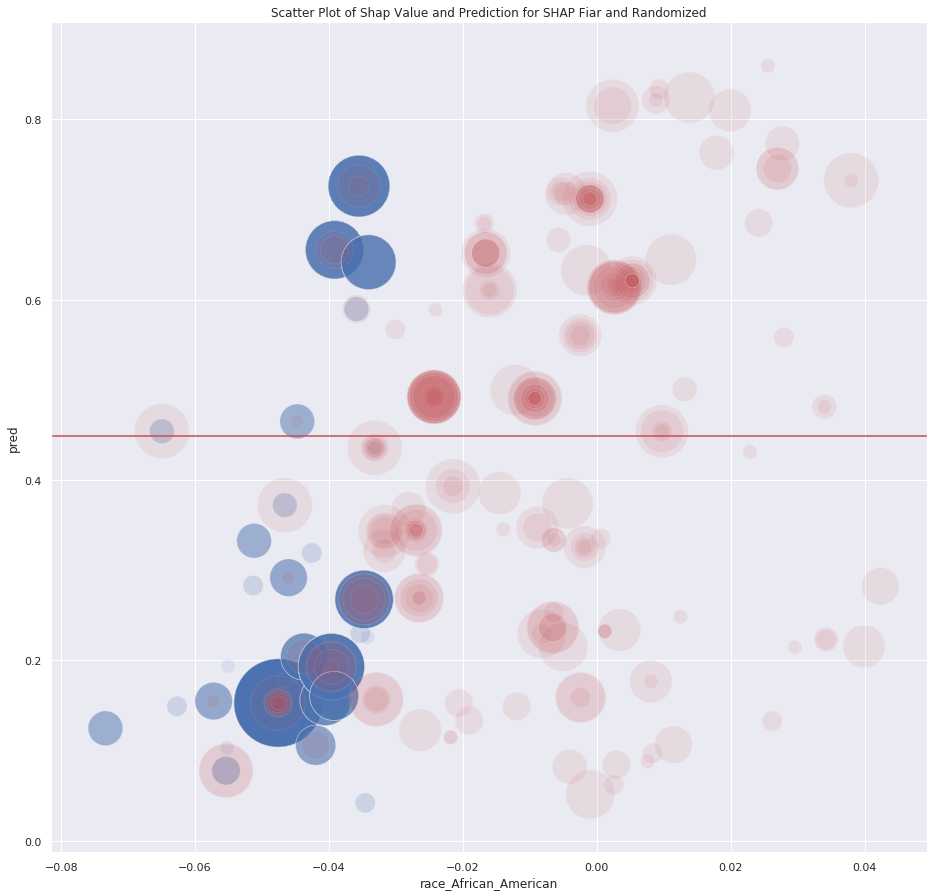

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,15.27)})
print(type(shap))
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]

sns.scatterplot(shap_shap, shap_pred, color = 'b', alpha = 0.1, s = weights_shap)
sns.scatterplot(random_shap, random_pred, color = 'r', alpha = 0.1, s = weights_random)

plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fiar and Randomized')
plt.axhline(y=base_rate, color='r', linestyle='-')

In [0]:
print("Base rate is ", base_rate )
shap_changed_data[shap_changed_data['pred'] >  base_rate]

Base rate is  0.44814814814814813


,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F,pred
id,,,,,,,,,,,
3365,12,0,1,0,1,0,0,1,1,0,0.453957
2020,12,0,1,0,1,0,0,1,1,0,0.453957
4736,12,0,1,0,1,0,0,1,1,0,0.453957
3260,12,0,1,0,1,0,0,1,0,1,0.464881
3147,12,0,1,0,1,0,0,1,0,1,0.464881
1144,12,0,1,0,1,0,0,1,0,1,0.464881
3062,12,0,1,0,1,0,0,1,0,1,0.464881
4674,12,0,1,0,1,0,0,1,0,1,0.464881
3137,12,0,1,0,1,0,0,1,0,1,0.464881


In [0]:
randomized_changed_data

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F,pred
836,4,1,0,0,1,0,0,1,0,1,0.333348
3590,2,0,0,1,1,0,0,1,0,1,0.152694
3749,4,1,0,0,1,0,1,0,0,1,0.481148
2610,0,1,0,0,1,0,0,1,1,0,0.651536
3907,1,0,1,0,1,0,1,0,1,0,0.809732
236,1,0,0,1,1,0,0,1,0,1,0.321134
3172,2,1,0,0,1,0,0,1,0,1,0.490304
3474,2,1,0,0,1,0,0,1,1,0,0.560325
4635,1,1,0,0,1,0,1,0,1,0,0.745177
1887,7,0,1,0,1,0,0,1,0,1,0.347212


In [0]:
randomized_changed_data[randomized_changed_data['pred'] >  base_rate]

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F,pred
836,4,1,0,0,1,0,0,1,0,1,0.666652
3590,2,0,0,1,1,0,0,1,0,1,0.847306
3749,4,1,0,0,1,0,1,0,0,1,0.518852
236,1,0,0,1,1,0,0,1,0,1,0.678866
3172,2,1,0,0,1,0,0,1,0,1,0.509696
3474,2,1,0,0,1,0,0,1,1,0,0.439675
1887,7,0,1,0,1,0,0,1,0,1,0.652788
3569,0,0,0,1,1,0,0,1,0,1,0.508024
1381,2,1,0,0,1,0,0,1,0,1,0.509696
329,28,0,1,0,1,0,0,1,0,1,0.867334


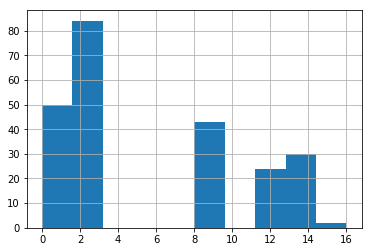

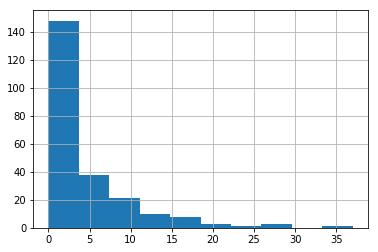

In [0]:
shap_changed_data.priors_count.hist(bins = 10)
plt.show()
randomized_changed_data.priors_count.hist(bins = 10)
plt.show()

# Distortion Metric between the two data points

In [0]:
class Dclass():
# adjust education
    def adjustPrior(self,v):
        if v=='0':
            return 0
        elif v=='1 to 3':
            return 1
        else:
            return 2

    def adjustAge(self,a):
        if a == 'Less than 25':
            return 0
        elif a == '25 to 45':
            return 1
        else:
            return 2

    # distortion metric
    def getDistortion(self,vold,vnew):
        '''
        Distortion metric.

        Inputs:
        *vold : dictionary of the form {attr:value} with old values
        *vnew : dictionary of the form {attr:value} with new values

        Output
        *d : distortion value
        '''

        # value that will be returned for events that should not occur
        bad_val = 1e4


        # Adjust prior
        pOld = self.adjustPrior(vold['priors_count'])
        pNew = self.adjustPrior(vnew['priors_count'])

        # Priors cannot be increased, or lowered by more than 1 category. A change has a unit penalty
        if (pNew>pOld)| (pNew<pOld-1):
            return bad_val

        # adjust age
        aOld = self.adjustAge(vold['age_cat'])
        aNew = self.adjustAge(vnew['age_cat'])

        # Age cannot be increased or decreased in more than one category
        if np.abs(aOld-aNew)>1.0:
            return bad_val
        
        # Recidivism should not be increased
        if vold['is_recid'] < vnew['is_recid']:
            return bad_val
        
        cum_sum = 0.0
        
        
        if np.abs(aOld-aNew)>0:
#             cum_sum+=1
#             cum_sum = cum_sum**2
           cum_sum = cum_sum+1
           
        # Penalty of 1 if priors is decreased or increased
        if np.abs(pNew-pOld)>0:
#             cum_sum+=1
#             cum_sum = cum_sum**2
            cum_sum = cum_sum+1
           

           #cum_sum = cum_sum**2
        if vold['is_recid'] > vnew['is_recid']:
#             cum_sum+=1
#             cum_sum = cum_sum**2
            cum_sum = cum_sum+1
           
       

       # final penalty of 2 for changing misdemeanor to felony and vice-verse
        if vold['c_charge_degree'] != vnew['c_charge_degree']:
#             cum_sum+=2
#             cum_sum = cum_sum**2
           cum_sum = cum_sum+4
            
        return cum_sum

# Extra Code !!! Dont USE

[1.36138506e+01 6.00130028e+00 3.43449614e+00 2.74670751e+00
 1.77393344e+00 1.48947337e+00 8.63597344e-01 2.89064134e-17
 0.00000000e+00 0.00000000e+00]


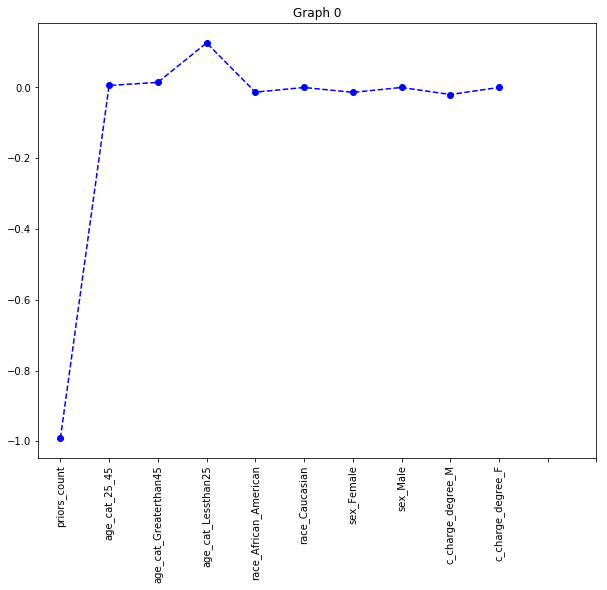

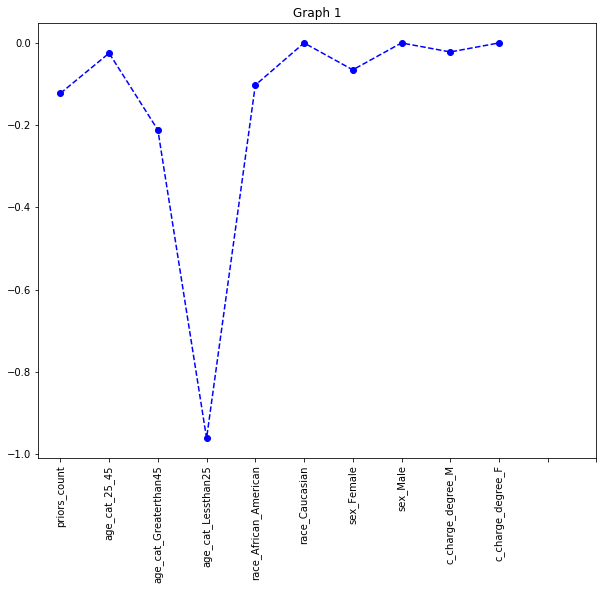

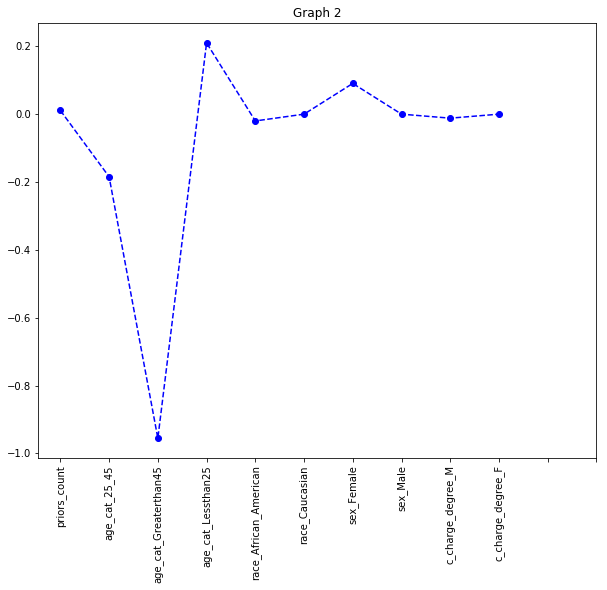

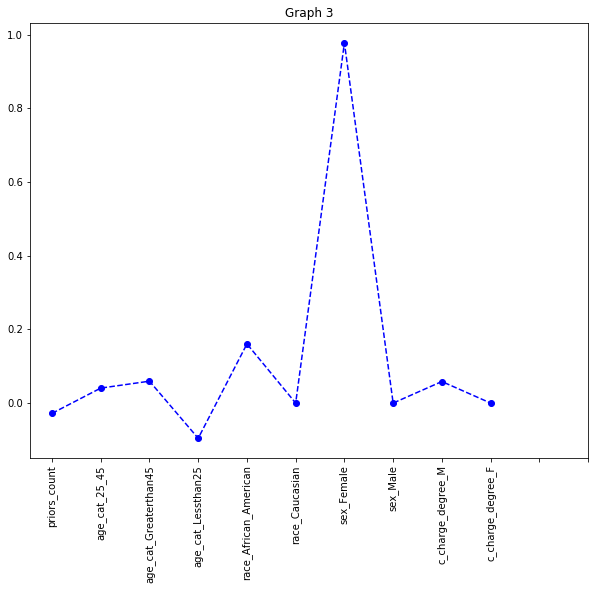

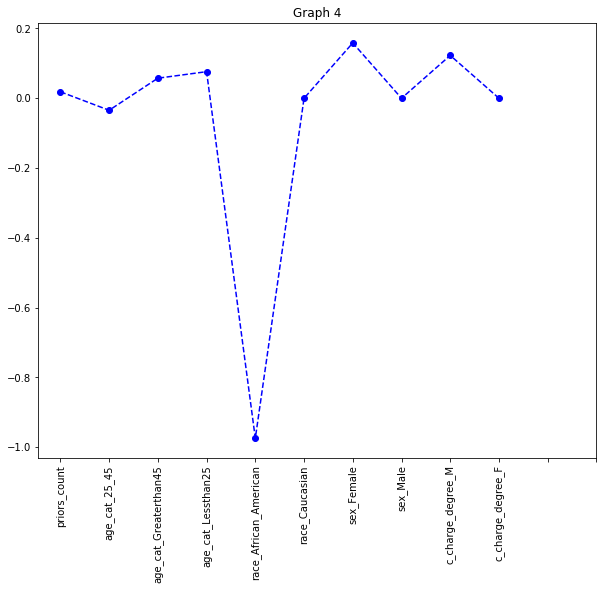

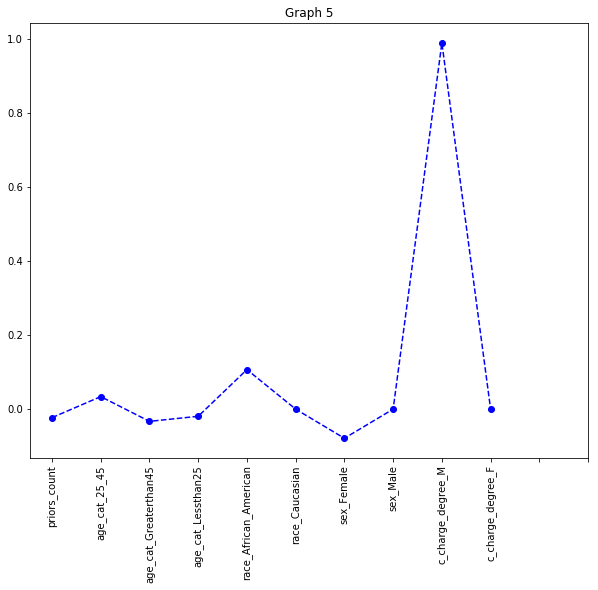

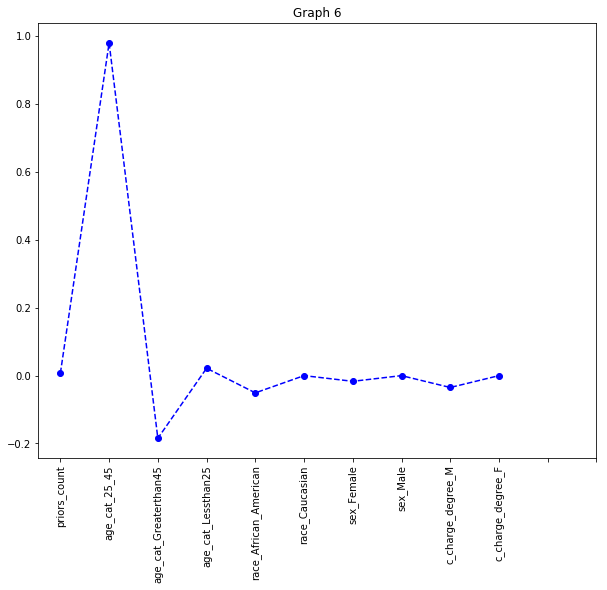

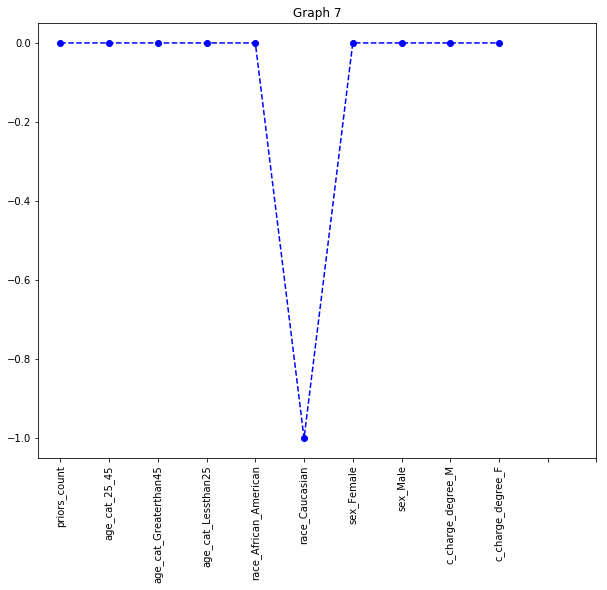

In [0]:
u,s,vh = svd(shap_values, False)
print(s)
for i in range(8):
    plt.figure(figsize=(10,8))
    plt.plot(vh[i],'--bo')
    plt.title('Graph '+ str(i))
    plt.xticks(range(12), X.columns, rotation = 90)
    plt.show()

In [0]:
u[102]

array([-1.15033668e-02, -6.89074156e-03,  7.57557264e-03,  2.11114734e-02,
        9.61903536e-03,  3.21554773e-02, -1.39973476e-02,  6.34635281e-04,
        7.42447421e-04, -4.03856152e-05])

#


In [0]:
sns.kdeplot(y_1_values[race_afam,0], label = 'African American Y = 1')
sns.kdeplot(y_0_values[:,0], label = 'African American Y = 0')

print("Mean value of Y = 1 actual race " + str(np.mean(y_1_values[:,0])))
print("Mean value of Y = 0 actual race " + str(np.mean(y_0_values[:,0])))

print("KL Divergence of the two distributions" + str(np.mean(y_0_values[:,0])))


IndexError: ignored

Mean value of Y = 1 random race 0.009440826
Mean value of Y = 0 random race -0.002954985


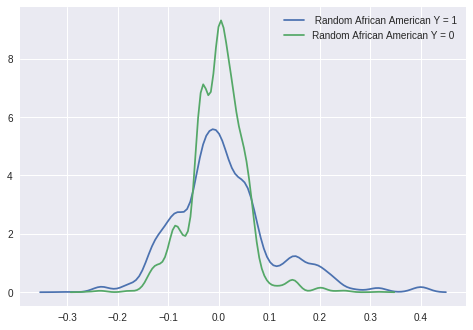

In [0]:
sns.kdeplot(y_1_values[:,2], label = ' Random African American Y = 1')
sns.kdeplot(y_0_values[:,2], label = 'Random African American Y = 0')

print("Mean value of Y = 1 random race " + str(np.mean(y_1_values[:,2])))
print("Mean value of Y = 0 random race " + str(np.mean(y_0_values[:,2])))

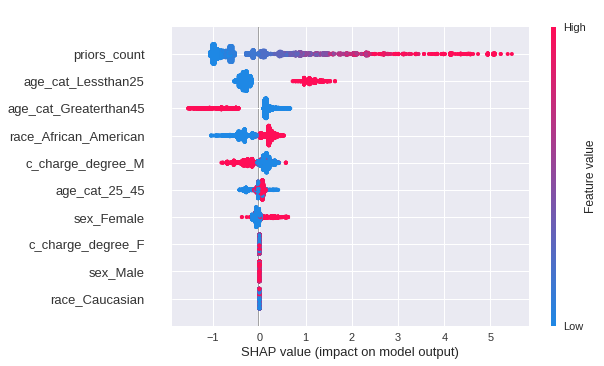

In [0]:
shap.summary_plot(shap_values, X)

In [0]:
race_total = np.sum(shap_values[:, locations_interested], axis = 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[1.        0.4364914]
 [0.4364914 1.       ]]
[[ 1. nan]
 [nan nan]]
[[1.        0.4364914]
 [0.4364914 1.       ]]


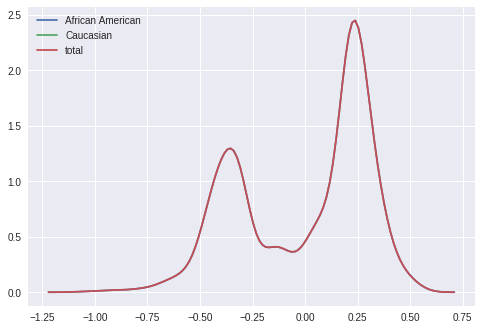

In [0]:
sns.kdeplot(shap_values[:,location_afam], label = 'African American')
sns.kdeplot(shap_values[:,location_caucasian], label = 'Caucasian')
sns.kdeplot(race_total, label = 'total')

print(np.corrcoef(data_final['pred'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_caucasian]))
print(np.corrcoef(data_final['pred'], race_total))

shap_df = pd.DataFrame(shap_values, columns = independent_columns)



In [0]:
shap_df.head()

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,race_Hispanic,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F
0,-0.885580,0.075000,0.111521,-0.299907,0.231805,0.000128,0.036940,-0.001671,0.0,0.161214,0.0
1,0.693717,0.145984,0.214665,1.102876,0.152156,0.040000,0.005197,-0.044442,0.0,0.046076,0.0
2,3.263394,0.075304,0.579669,-0.193985,-0.585169,-0.397150,0.036854,-0.082842,0.0,0.200138,0.0
3,-0.970377,0.056284,0.186682,-0.448995,-0.231974,0.131869,0.080414,0.244301,0.0,-0.325195,0.0
4,-0.823680,0.084322,0.111674,-0.291066,-0.257937,-0.030508,0.036470,-0.060879,0.0,0.210234,0.0


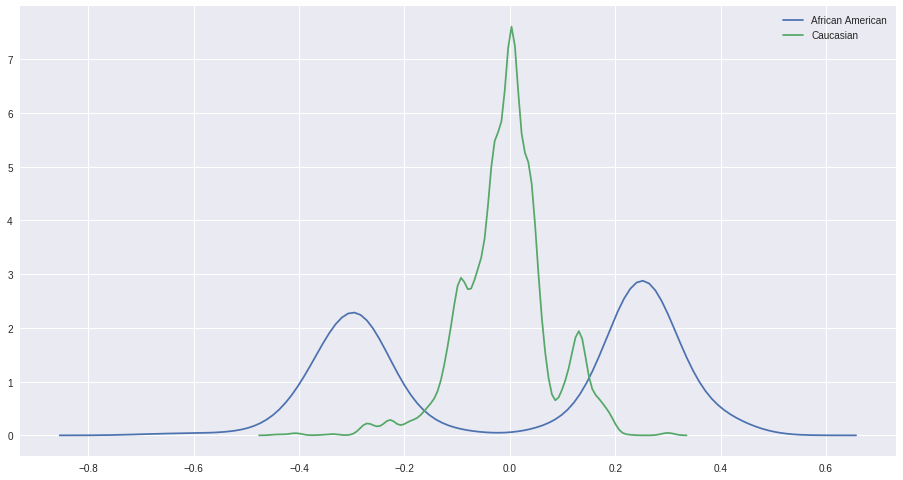

In [0]:
sns.kdeplot(shap_values[:,location_afam], label = 'African American')
sns.kdeplot(shap_values[:,location_caucasian], label = 'Caucasian')


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


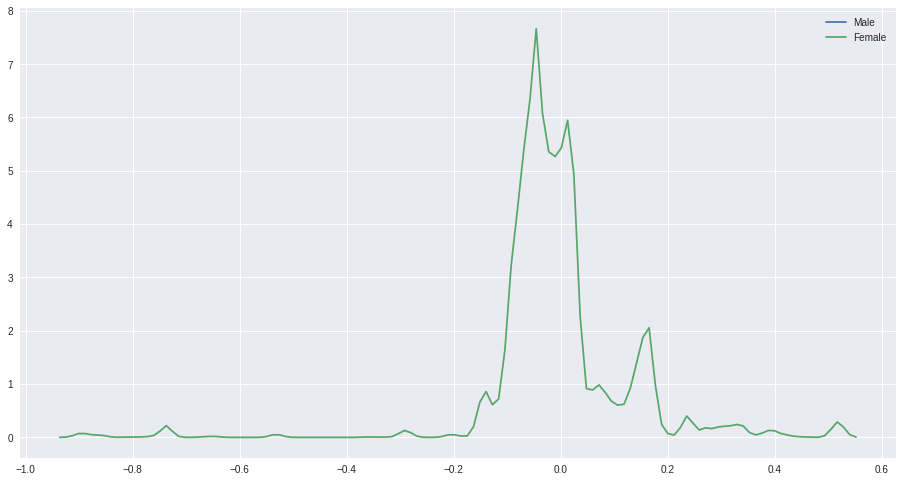

In [0]:
sns.kdeplot(shap_values[:,location_male], label = 'Male')
sns.kdeplot(shap_values[:,location_female], label = 'Female')


The above figure shows the distribution of the SHAP values for two one hot encoded feature vectors representing if the race of the person is African American (blue) or the race is Caucasian (green).  Demographic Parity requires independence between the protected attribute

Possible Analysis Ideas ;
2. Rank of highest positive and negative exaplanations
3. Debisas the system using a fairness algorithm and use shapelye values again

Questions to ask:
1. Defining fairness in terms of explanation. Look at Exposure terms
2. Counterfactual estimation

SHAPLEY TO FAIRNESS TRANFORM


*  Dummy players should get 0 value 
*   Shapley axioms, If i and j are interchangeable, they should get equal values
*  Additivity Cooperative game is sum of values fo both individual games
*   List item




Fairness Definitions

Well calibrated Compas scores


1.  Statistical Bias- Difference between estimators expected value and true value.  Doesnot say anything about for errors or distribution of errors
2.   How Algorithmic Systems Support Human Values


*  Group Fairness - outcome fairness

>   Predictive Parity and different base rates imples equal FPR and FNR cannot be achieved

Different Stakeholders have different interest
Decision Maker = TP/(FP+TP) Predictive Value

Defendant:  FPR = FP /(TN+FP)

Society: Demography 










In [0]:
X_set =  X.iloc[tp_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
tp_val =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[fn_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")

fn_val =  shap_values_set[:, locations_interested]
#plt.hist(fnr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[fp_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
fp_val =  shap_values_set[:, locations_interested]
#plt.hist(fpr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[tn_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
tn_val =  shap_values_set[:, locations_interested]
#plt.hist(tnr_val, bins = 20)
plt.show()

In [0]:
print(np.corrcoef(data_final['decile_score'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['decile_score'], shap_values[:,location_caucasian]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_caucasian]))

[[1.         0.28159559]
 [0.28159559 1.        ]]
[[1.         0.12600542]
 [0.12600542 1.        ]]
[[1.         0.42793318]
 [0.42793318 1.        ]]
[[1.         0.20657408]
 [0.20657408 1.        ]]


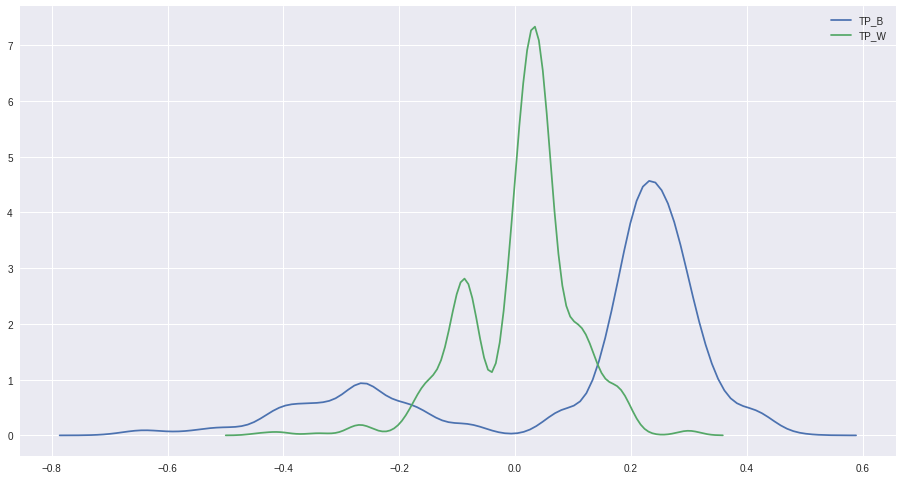

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.kdeplot(tp_val[:,0],label = 'TP_B')
sns.kdeplot(tp_val[:,1],label = 'TP_W')


#sns.kdeplot(fp_val,label = 'FP')
#sns.kdeplot(tn_val,label = 'TN')
# sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()


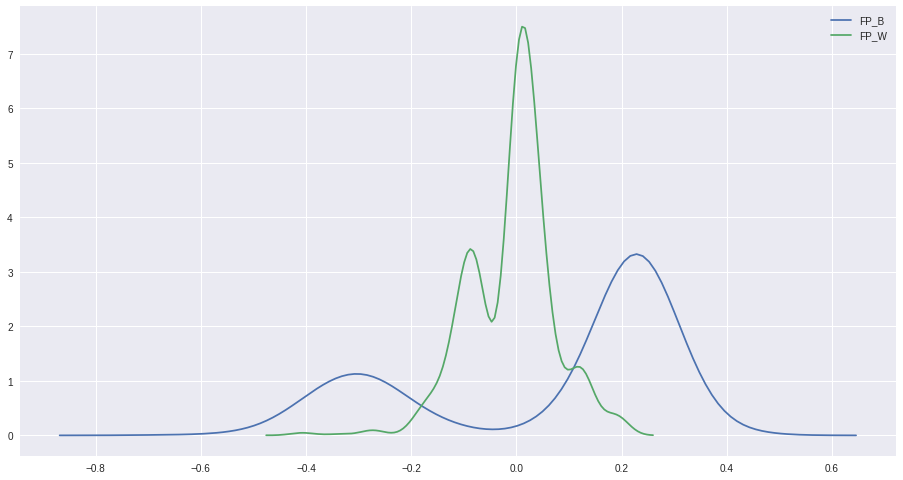

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
sns.kdeplot(fp_val[:,0],label = 'FP_B')
sns.kdeplot(fp_val[:,1],label = 'FP_W')

#sns.kdeplot(tn_val,label = 'TN')
#sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

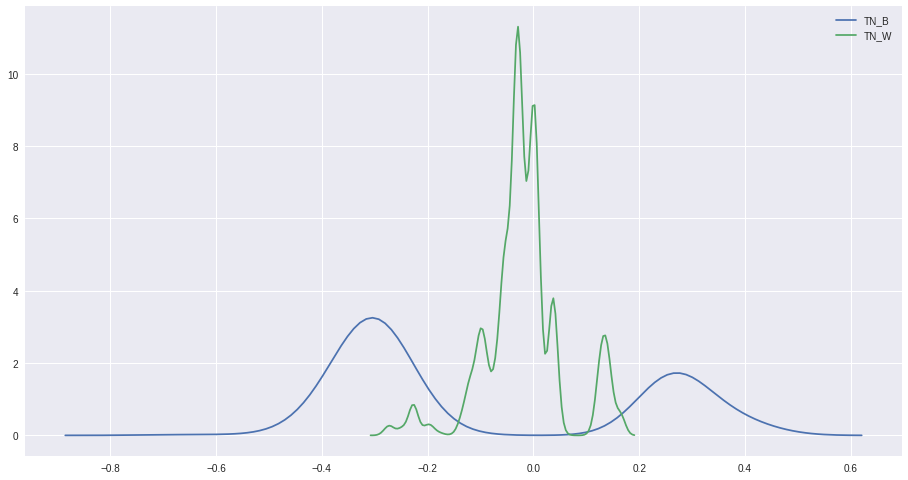

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
#sns.kdeplot(fp_val,label = 'FP')
sns.kdeplot(tn_val[:,0],label = 'TN_B')
sns.kdeplot(tn_val[:,1],label = 'TN_W')

#sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

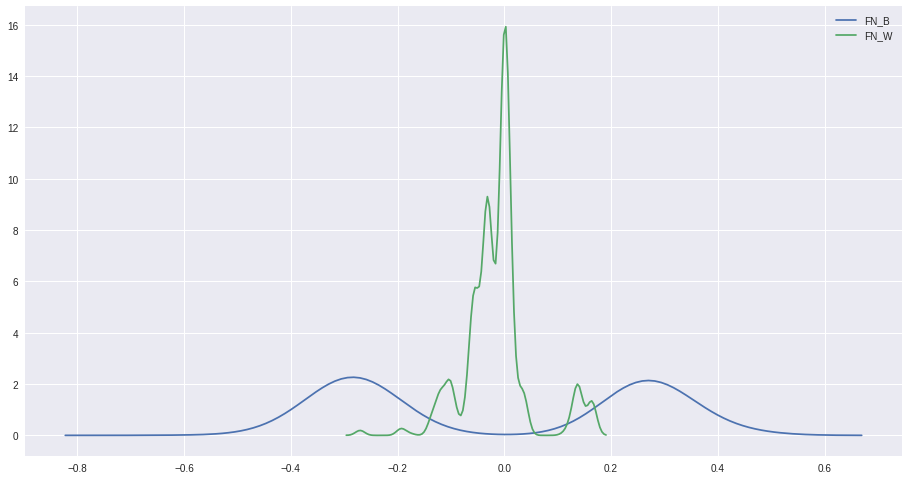

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
#sns.kdeplot(fp_val,label = 'FP')
#sns.kdeplot(tn_val,label = 'TN')
sns.kdeplot(fn_val[:,0],label = 'FN_B')
sns.kdeplot(fn_val[:,1],label = 'FN_W')

#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

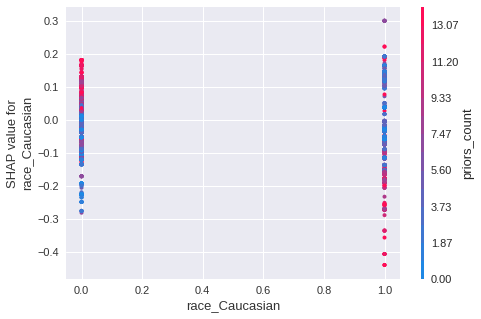

In [0]:

shap.dependence_plot( "race_Caucasian",
    shap_values, X, interaction_index = 'priors_count')




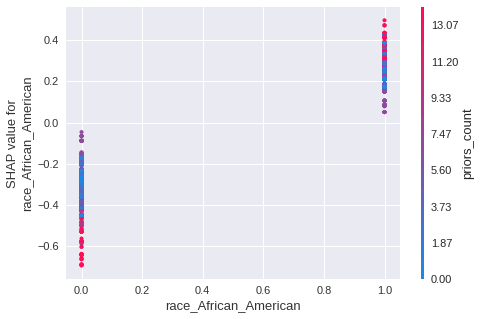

In [0]:

shap.dependence_plot( "race_African_American",
    shap_values, X, interaction_index = 'priors_count')




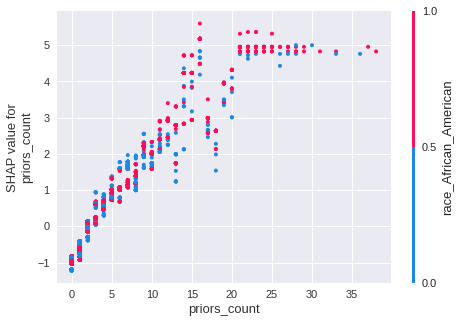

In [0]:

shap.dependence_plot( "priors_count",
    shap_values, X, interaction_index = 'race_African_American')



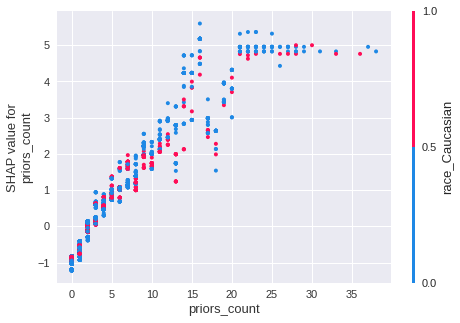

In [0]:
shap.dependence_plot( "priors_count",
    shap_values, X, interaction_index = 'race_Caucasian')


In [0]:
sprshap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

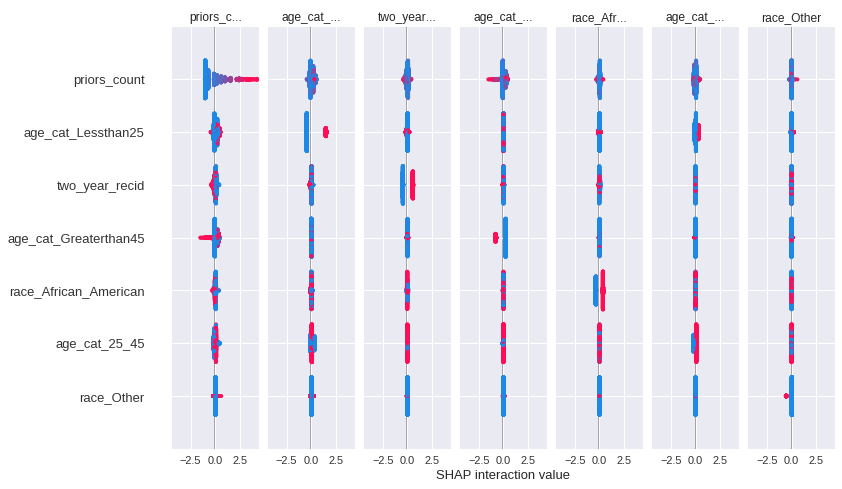

In [0]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

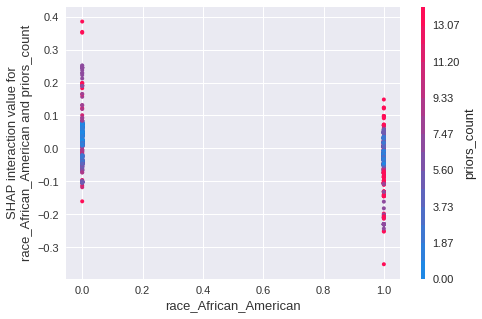

In [0]:


shap.dependence_plot(
    ("race_African_American", "priors_count"),
    shap_interaction_values, X.iloc[:2000,:]
)



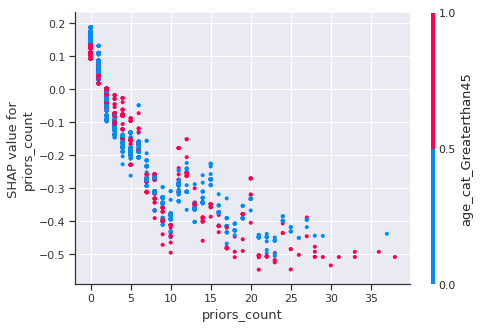

In [0]:
shap.dependence_plot("priors_count", shap_values, X)

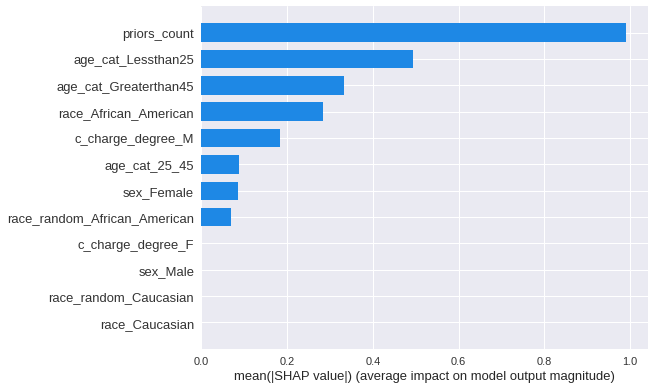

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

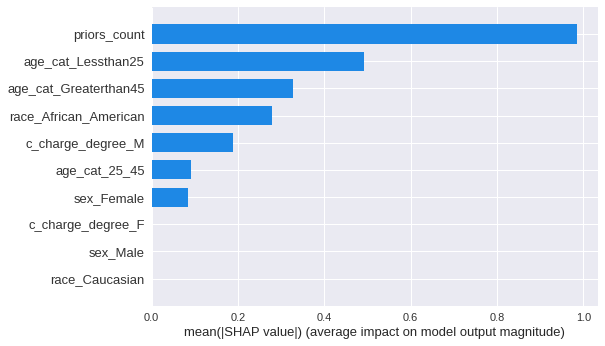

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [0]:
import statsmodels.api as sm

model =  sm.formula.glm("score_factor ~ priors_count + two_year_recid +\
       age_cat_25_45 + age_cat_Greaterthan45 + \
       age_cat_Lessthan25 + race_African_American  + \
       race_Caucasian   + \
       sex_Female + sex_Male" \
      , family =  sm.families.Binomial() , data =  data_final).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Generalized Linear Model Regression Results                                 
=============================================================================================================
Dep. Variable:     ['score_factor[Low]', 'score_factor[MediumHigh]']   No. Observations:                 5278
Model:                                                           GLM   Df Residuals:                     5271
Model Family:                                               Binomial   Df Model:                            6
Link Function:                                                 logit   Scale:                             1.0
Method:                                                         IRLS   Log-Likelihood:                -2718.9
Date:                                               Sun, 31 Mar 2019   Deviance:                       5437.8
Time:                                                       08:18:32   Pearson chi2:                 5.27e+03
No. Iterations:                                                    6                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5585      0.026     21.701      0.000       0.508       0.609
priors_count             -0.2730      0.012    -23.204      0.000      -0.296      -0.250
two_year_recid           -0.7100      0.068    -10.451      0.000      -0.843      -0.577
age_cat_25_45             0.1551      0.045      3.482      0.000       0.068       0.242
age_cat_Greaterthan45     1.5134      0.074     20.465      0.000       1.368       1.658
age_cat_Lessthan25       -1.1099      0.059    -18.884      0.000      -1.225      -0.995
race_African_American     0.0314      0.036      0.866      0.386      -0.040       0.102
race_Caucasian            0.5271      0.037     14.059      0.000       0.454       0.601
sex_Female                0.1305      0.047      2.773      0.006       0.038       0.223
sex_Male                  0.4280      0.040     10.784      0.000       0.350       0.506
=========================================================================================
"""

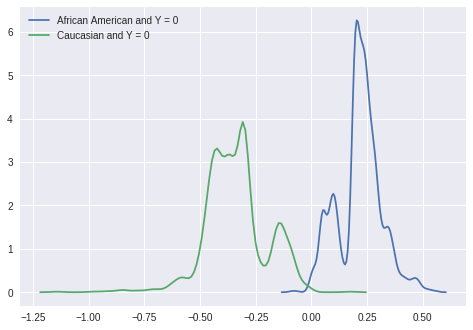

In [0]:
sns.kdeplot(y_0_afam_values[:,0], label = 'African American and Y = 0')
sns.kdeplot(y_0_caucasian_values[:,0], label = 'Caucasian and Y = 0')

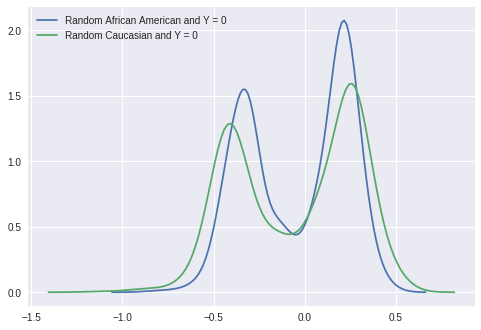

In [0]:
sns.kdeplot(y_0_afam_random_values[:,0], label = 'Random African American and Y = 0')
sns.kdeplot(y_0_caucasian_random_values[:,0], label = 'Random Caucasian and Y = 0')

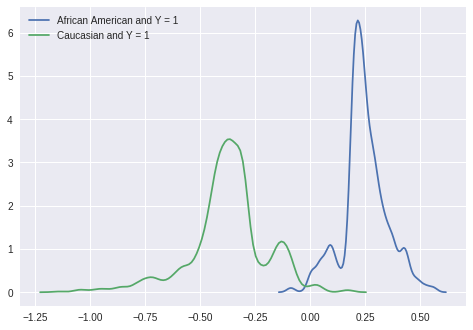

In [0]:
sns.kdeplot(y_1_afam_values[:,0], label = 'African American and Y = 1')
sns.kdeplot(y_1_caucasian_values[:,0], label = 'Caucasian and Y = 1')